In [19]:
import itertools
import numpy as np
import pandas as pd
from utils.base_models import BaseModels
from utils.numerical_scalers import NumericalScalers
from utils.categorical_encoders import CategoricalEncoders

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### 1. Leer datos

In [2]:
# 1. Leer el dataset
dataset = pd.read_parquet('./data/2_data_preprocesada.parquet')
dataset = dataset.drop(columns=['DF_TYPE'])
dataset

,FBK_ULT12,FBK_BEST12,COD_SALA,DEPARTAMENTO,SEGMENTO,RANGO_INGRESOS,NUMPRIORIZACION,NC_DISTR12,TOTGEST6,DIAS_ULT6,DIAS_BEST12,NC_CTD12,NC_DIAS6,TARGET
0,TLV,TLV,EC,FUERA DE LIMA,2,Entre S/.4000-10000,1,0.333333,6.000000,8.000000,8.000000,2.0,58.0,1
1,TLV,TLV,PP,LIMA,1BC,Entre S/.4000-10000,1,0.461538,13.000000,9.000000,46.000000,6.0,9.0,1
2,TLV,TLV,PA,LIMA,2,Entre S/.1000-4000,1,0.666667,2.000000,127.000000,223.000000,4.0,127.0,1
3,TLV,TLV,NC,LIMA,2,Entre S/.1000-4000,1,0.587062,4.000000,49.000000,49.000000,4.0,38.0,1
4,TLV,TLV,EC,FUERA DE LIMA,3,Entre S/.4000-10000,1,0.187500,10.000000,27.000000,27.000000,3.0,140.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305600,SIN DATOS,SIN DATOS,NC,FUERA DE LIMA,5,Entre S/.600-1000,1,0.587062,7.463895,44.627989,80.041789,4.0,38.0,0
1305601,SIN DATOS,SIN DATOS,2DA,FUERA DE LIMA,1BC,Entre S/.4000-10000,1,0.587062,7.463895,44.627989,80.041789,4.0,38.0,0
1305602,SIN DATOS,SIN DATOS,NC,LIMA,3,Sin ingresos,1,0.587062,7.463895,44.627989,80.041789,4.0,38.0,1
1305603,SIN DATOS,SIN DATOS,NC,LIMA,3,Entre S/.1000-4000,2,0.587062,7.463895,44.627989,80.041789,4.0,38.0,0


### 2. Generar combinaciones de categóricos y numéricos

In [11]:
# 2. Separar TARGET, df_categorical y df_numeric
df_target = dataset['TARGET']
df_categorical = dataset.select_dtypes(include=['object'])
df_numeric = dataset.select_dtypes(include=['float64', 'int64'])

# 3. Eliminar TARGET de df_numeric
df_numeric = df_numeric.drop(columns=['TARGET'])

In [12]:
# 4. Generar las combinaciones de Encoder y Scaler
encoder_methods = ['LabelEncoder', 'OneHotEncoder', 'OrdinalEncoder', 'FrequencyEncoder', 'BinaryEncoder', 'BackwardDifferenceEncoder']
scaler_methods = ['StandardScaler', 'MinMaxScaler', 'MaxAbsScaler', 'RobustScaler', 'Normalizer', 'PowerTransformer']

# 5. Instanciar CategoricalEncoders
categorical = CategoricalEncoders(dataset=df_categorical)
binary_columns, categorical_columns = categorical.get_binary_categorical_columns()

# 6. Instanciar NumericalScalers
numerical = NumericalScalers(dataset=df_numeric)

# 7. Generar todas las combinaciones de Encoder y Scaler
def get_list_data_processed(encoder_methods, scaler_methods):
    combinations = list(itertools.product(encoder_methods, scaler_methods))
    
    i=0
    list_data_processed = []
    for encoder_method, scaler_method in combinations:
        data_encoded = categorical.provider(binary_columns, categorical_columns, method=encoder_method)
        data_scaled = numerical.provider(method=scaler_method)

        processed_data = pd.concat([data_encoded, data_scaled], axis=1)
        list_data_processed.append((f'{encoder_method} - {scaler_method}', processed_data))
        print(f'{str(i).zfill(2)} -> Encoder: {encoder_method} - Scaler: {scaler_method} - Shape: {processed_data.shape}')
        i+=1
    
    return list_data_processed

list_data_processed = get_list_data_processed(encoder_methods, scaler_methods)

00 -> Encoder: LabelEncoder - Scaler: StandardScaler - Shape: (1305605, 13)
01 -> Encoder: LabelEncoder - Scaler: MinMaxScaler - Shape: (1305605, 13)
02 -> Encoder: LabelEncoder - Scaler: MaxAbsScaler - Shape: (1305605, 13)
03 -> Encoder: LabelEncoder - Scaler: RobustScaler - Shape: (1305605, 13)
04 -> Encoder: LabelEncoder - Scaler: Normalizer - Shape: (1305605, 13)
05 -> Encoder: LabelEncoder - Scaler: PowerTransformer - Shape: (1305605, 13)
06 -> Encoder: OneHotEncoder - Scaler: StandardScaler - Shape: (1305605, 39)
07 -> Encoder: OneHotEncoder - Scaler: MinMaxScaler - Shape: (1305605, 39)
08 -> Encoder: OneHotEncoder - Scaler: MaxAbsScaler - Shape: (1305605, 39)
09 -> Encoder: OneHotEncoder - Scaler: RobustScaler - Shape: (1305605, 39)
10 -> Encoder: OneHotEncoder - Scaler: Normalizer - Shape: (1305605, 39)
11 -> Encoder: OneHotEncoder - Scaler: PowerTransformer - Shape: (1305605, 39)
12 -> Encoder: OrdinalEncoder - Scaler: StandardScaler - Shape: (1305605, 13)
13 -> Encoder: Ordin

### 3. Split test y train de cada dataset

In [13]:
# 4. Generar los conjuntos de entrenamiento y prueba
def get_list_split_data(list_data_processed):
    i=0
    list_split_data = []
    for encoded_scaler, data_processed in list_data_processed:
        X = data_processed
        y = df_target
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        list_split_data.append((encoded_scaler, X_train, X_test, y_train, y_test))
        print(f'{str(i).zfill(2)} -> Split Encoded Scaler Method: {encoded_scaler}')
        i+=1

    return list_split_data

list_split_data = get_list_split_data(list_data_processed)

00 -> Split Encoded Scaler Method: LabelEncoder - StandardScaler
01 -> Split Encoded Scaler Method: LabelEncoder - MinMaxScaler
02 -> Split Encoded Scaler Method: LabelEncoder - MaxAbsScaler
03 -> Split Encoded Scaler Method: LabelEncoder - RobustScaler
04 -> Split Encoded Scaler Method: LabelEncoder - Normalizer
05 -> Split Encoded Scaler Method: LabelEncoder - PowerTransformer
06 -> Split Encoded Scaler Method: OneHotEncoder - StandardScaler
07 -> Split Encoded Scaler Method: OneHotEncoder - MinMaxScaler
08 -> Split Encoded Scaler Method: OneHotEncoder - MaxAbsScaler
09 -> Split Encoded Scaler Method: OneHotEncoder - RobustScaler
10 -> Split Encoded Scaler Method: OneHotEncoder - Normalizer
11 -> Split Encoded Scaler Method: OneHotEncoder - PowerTransformer
12 -> Split Encoded Scaler Method: OrdinalEncoder - StandardScaler
13 -> Split Encoded Scaler Method: OrdinalEncoder - MinMaxScaler
14 -> Split Encoded Scaler Method: OrdinalEncoder - MaxAbsScaler
15 -> Split Encoded Scaler Method

### 4. Entrenar con la lista de modelos

In [21]:
# Inicializar BaseModels y definir los nombres de los modelos
base_models = BaseModels()
name_models = ['logistic_regression', 'decision_tree']

# Variable para almacenar los resultados
all_results = []

# Iterar sobre los conjuntos de datos codificados
i = 0
for encoded_method, X_train, X_test, y_train, y_test in list_split_data:
    results = []
    for name in name_models:
        model = base_models.provider(name)
        model.fit(X_train, y_train)
        
        predict_train = model.predict_proba(X_train)[:, 1]
        predict_test = model.predict_proba(X_test)[:, 1]
        predict_test_class = model.predict(X_test)

        train_auc = roc_auc_score(y_train, predict_train)
        test_auc = roc_auc_score(y_test, predict_test)

        results.append((name, train_auc, test_auc, y_test, predict_test_class))

        print(f'{str(i).zfill(2)} <->')
        print(f"Encoded Method: {encoded_method} - AUC on training data with {name}: {train_auc:.3f}")
        print(f"AUC on testing data with {name}: {test_auc:.3f}\n")
        i += 1

    # Ordenar los resultados por test_auc de mayor a menor
    results.sort(key=lambda x: x[2], reverse=True)

    # Desempaquetar los resultados ordenados y almacenar con el método de codificación
    sorted_names, train_aucs, test_aucs, y_tests, predict_test_classes = zip(*results)
    all_results.append((encoded_method, sorted_names, train_aucs, test_aucs, y_tests, predict_test_classes))

00 <->
Encoded Method: LabelEncoder - StandardScaler - AUC on training data with logistic_regression: 0.805
AUC on testing data with logistic_regression: 0.805

01 <->
Encoded Method: LabelEncoder - StandardScaler - AUC on training data with decision_tree: 0.983
AUC on testing data with decision_tree: 0.786

02 <->
Encoded Method: LabelEncoder - MinMaxScaler - AUC on training data with logistic_regression: 0.803
AUC on testing data with logistic_regression: 0.803

03 <->
Encoded Method: LabelEncoder - MinMaxScaler - AUC on training data with decision_tree: 0.983
AUC on testing data with decision_tree: 0.785

04 <->
Encoded Method: LabelEncoder - MaxAbsScaler - AUC on training data with logistic_regression: 0.803
AUC on testing data with logistic_regression: 0.803

05 <->
Encoded Method: LabelEncoder - MaxAbsScaler - AUC on training data with decision_tree: 0.983
AUC on testing data with decision_tree: 0.785

06 <->
Encoded Method: LabelEncoder - RobustScaler - AUC on training data with

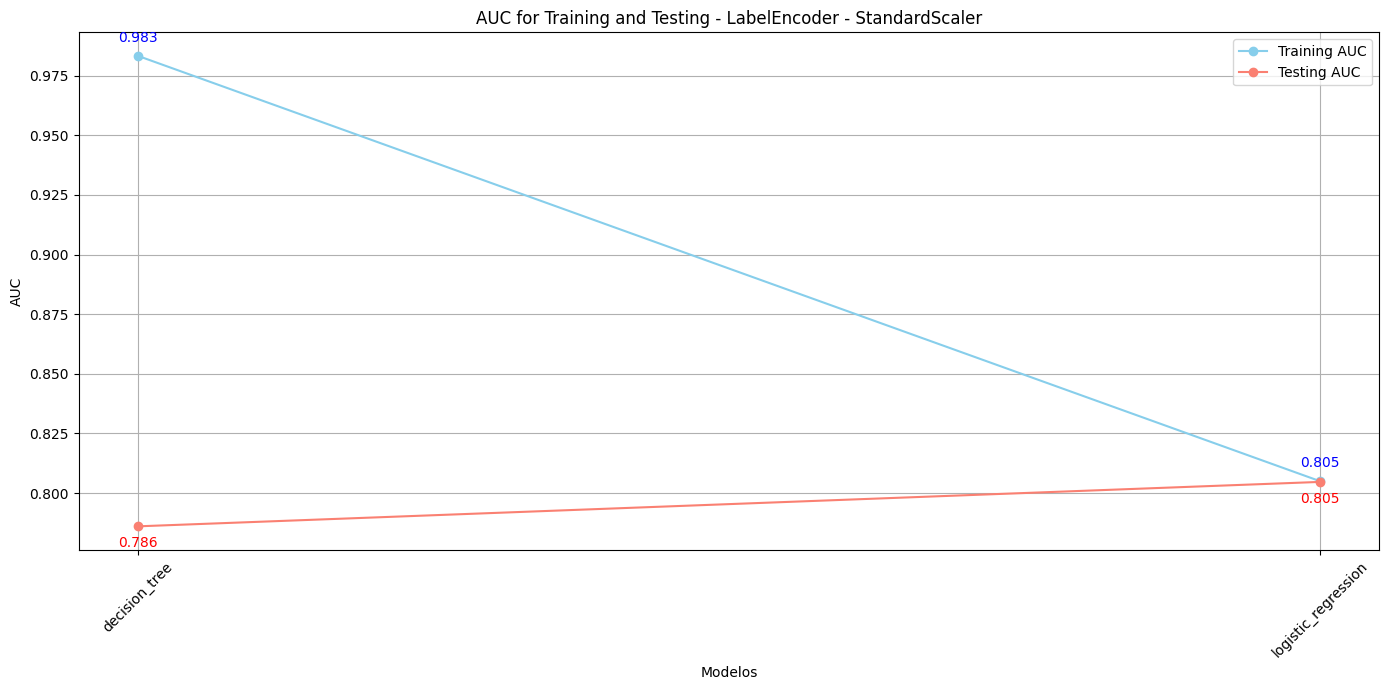

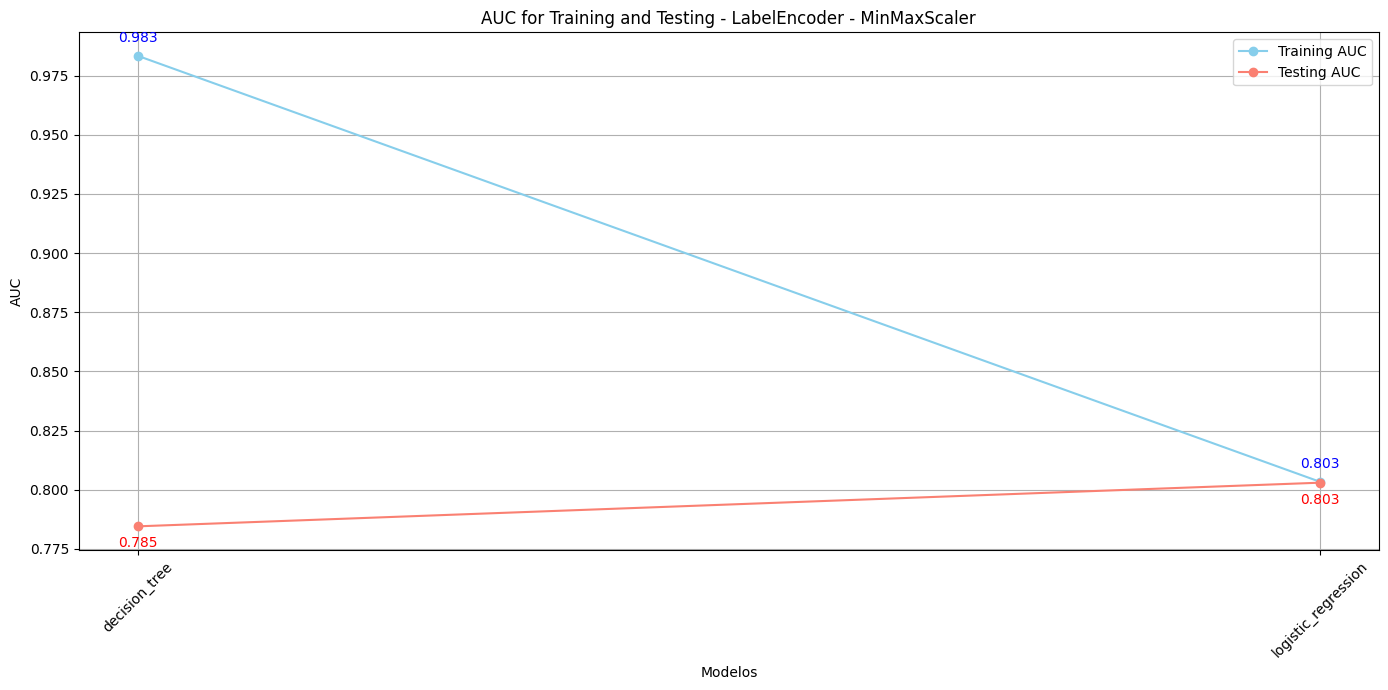

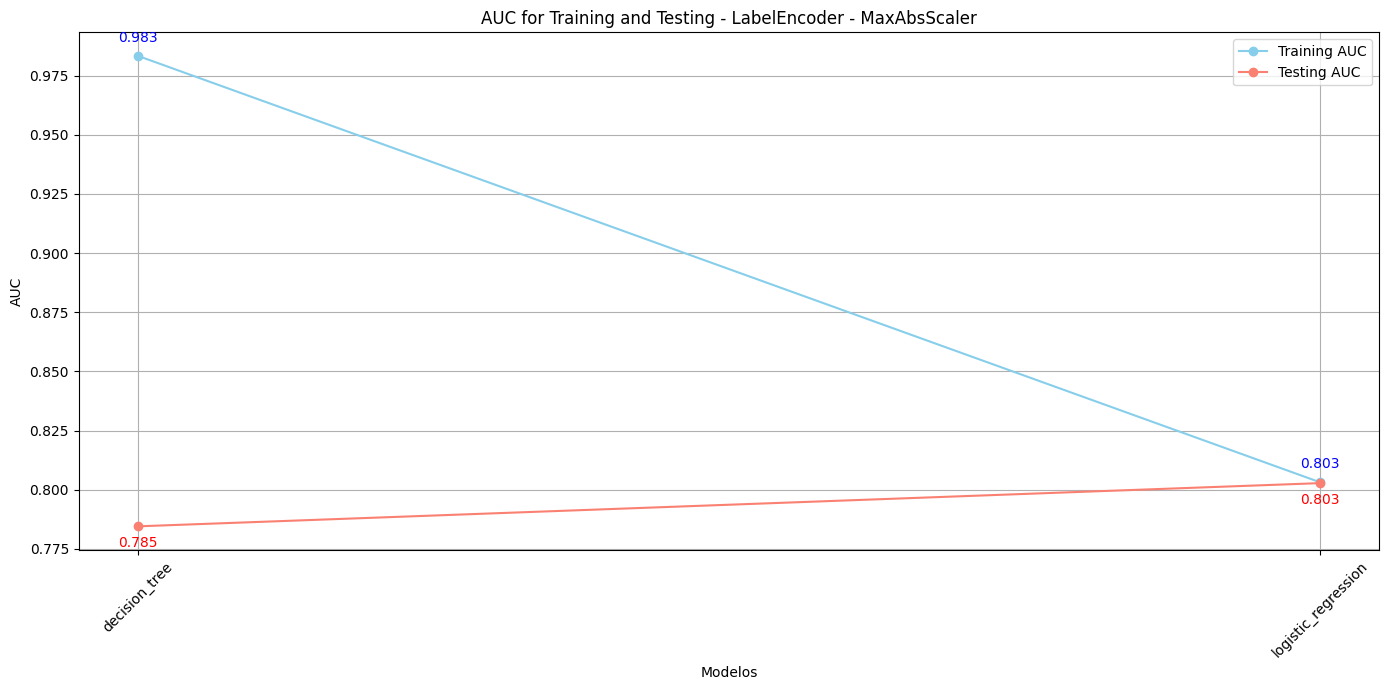

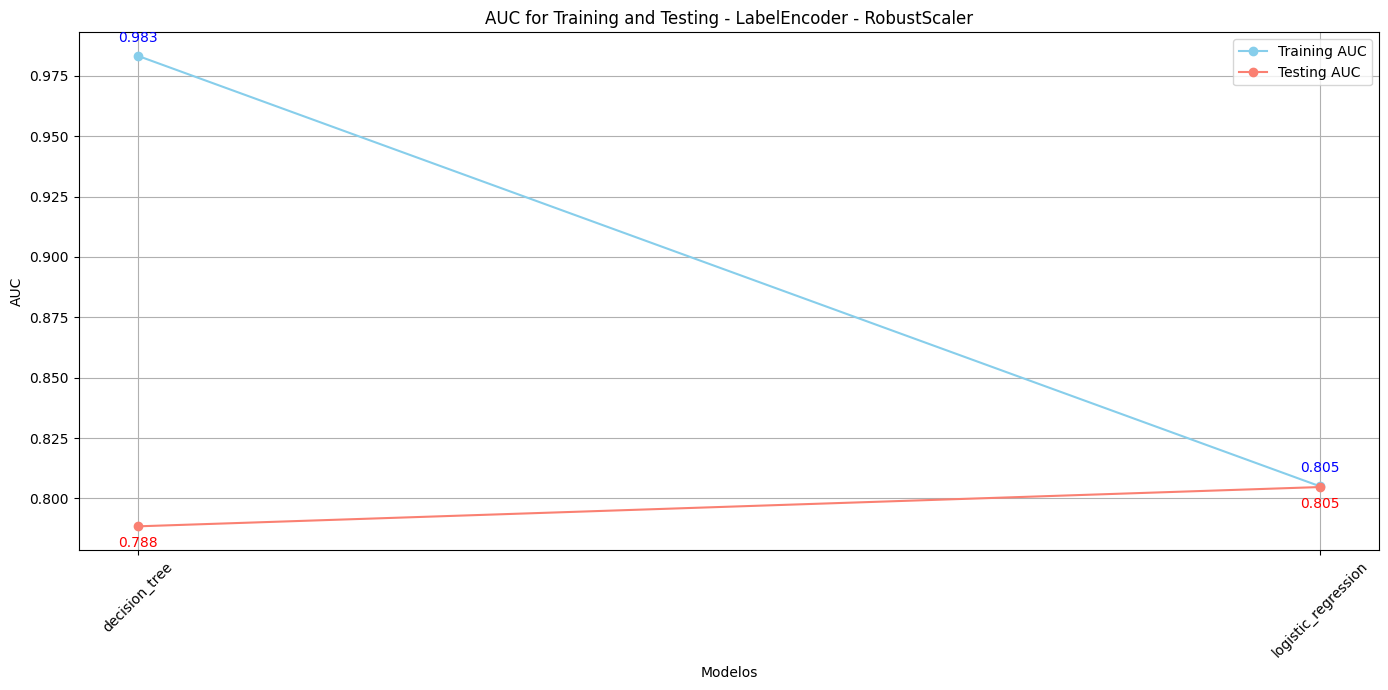

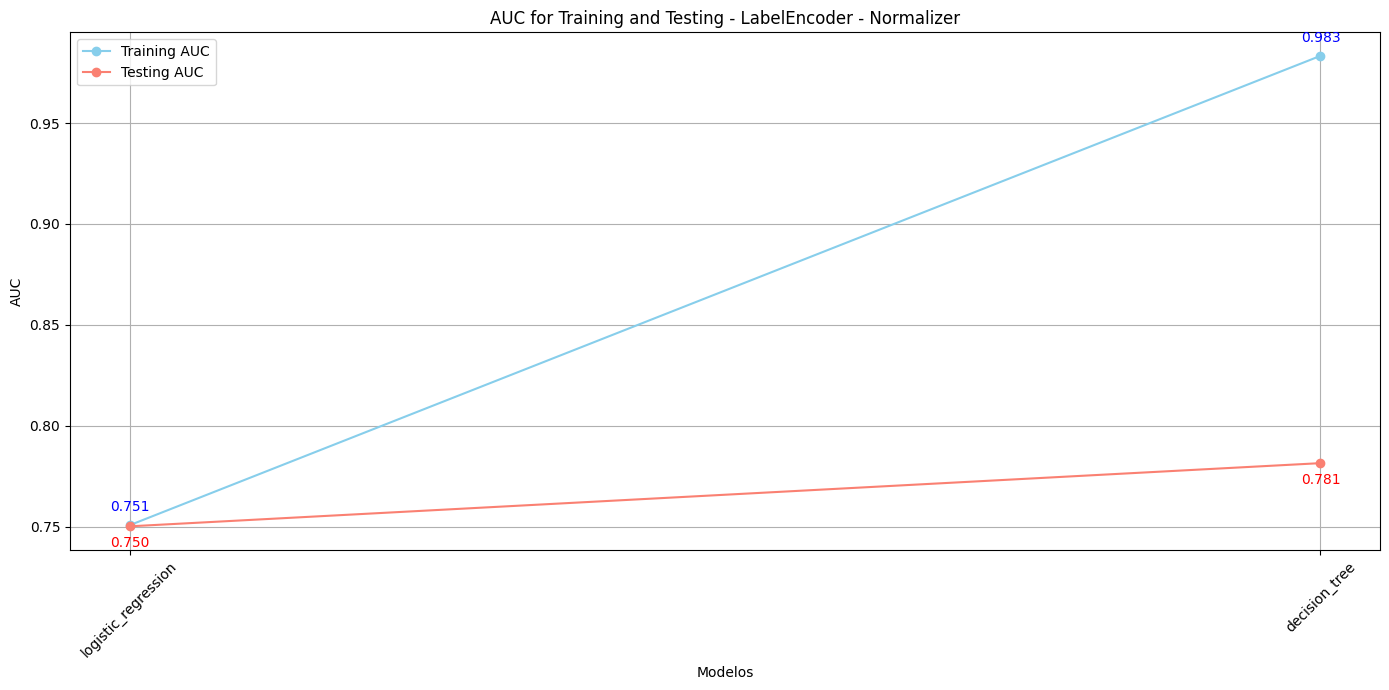

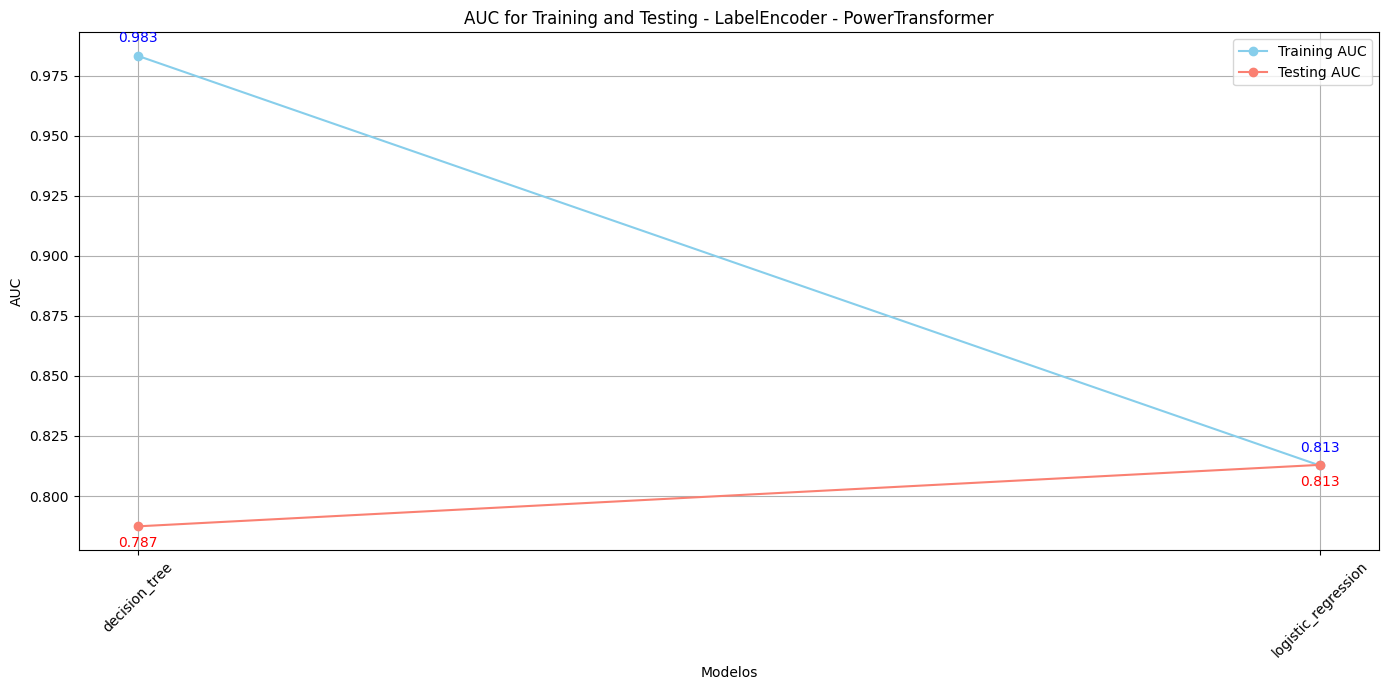

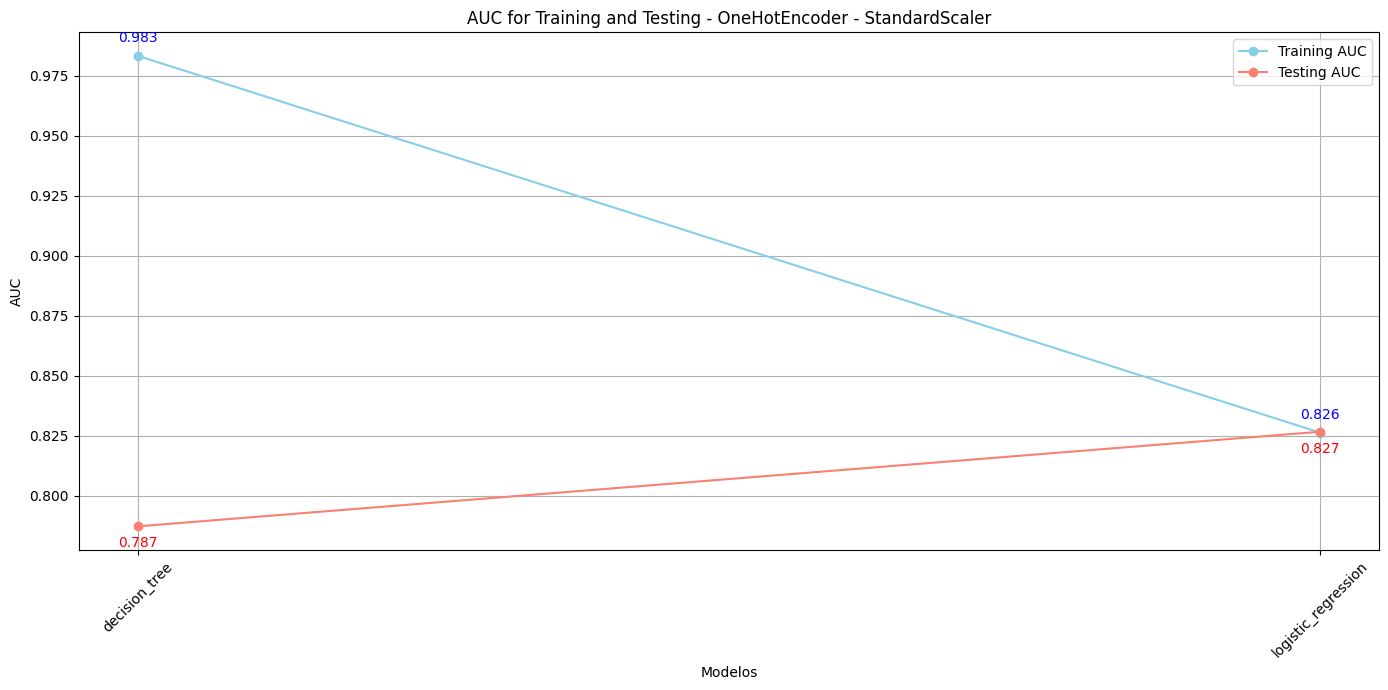

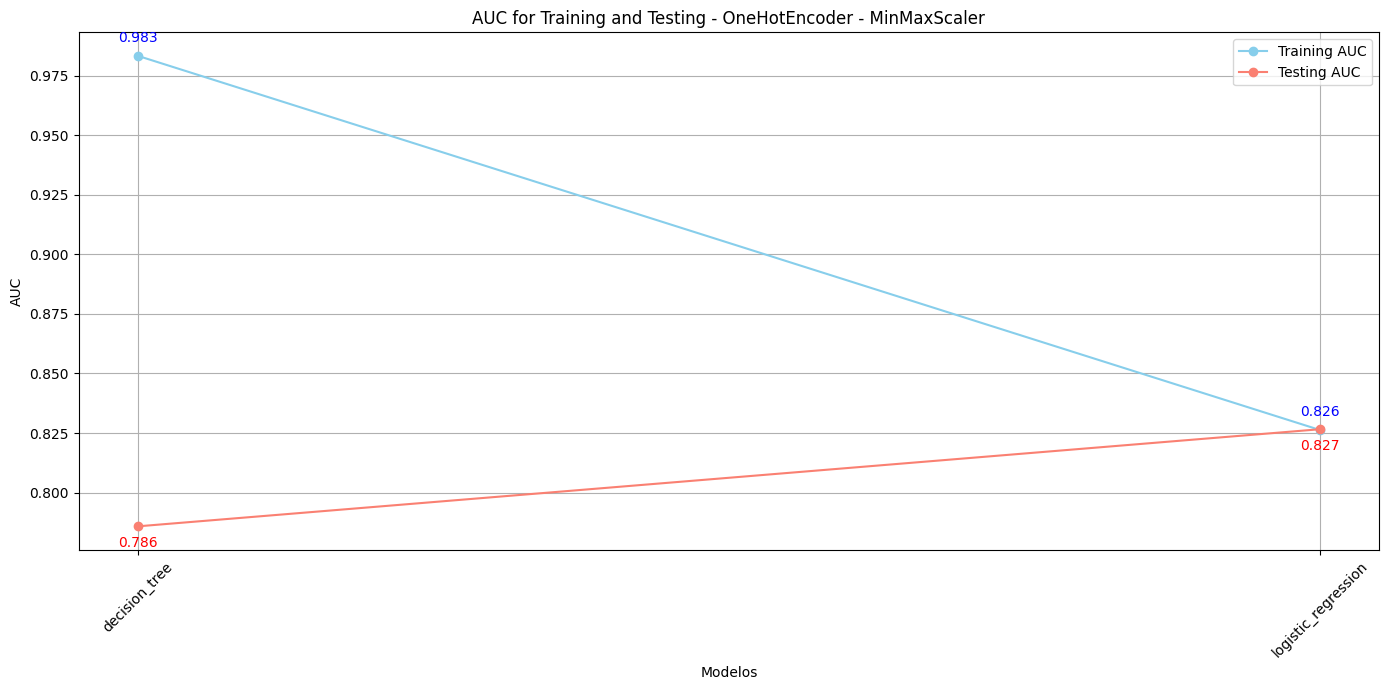

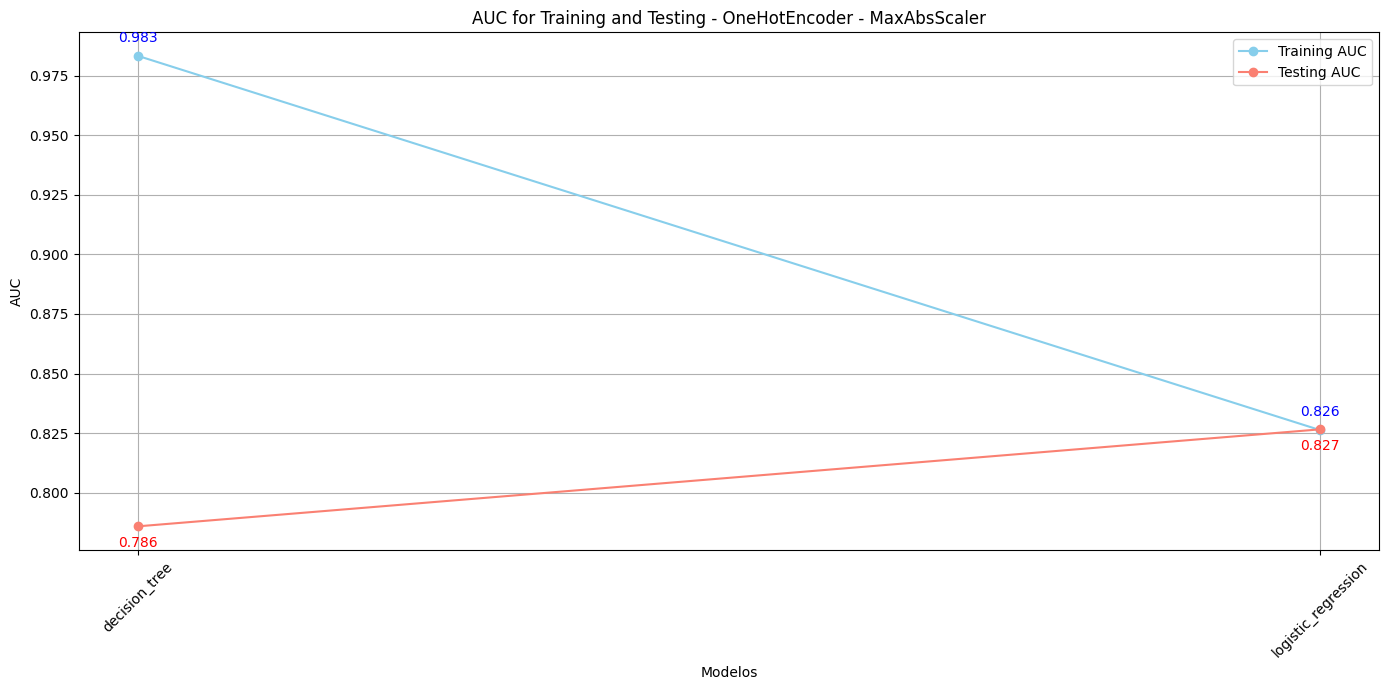

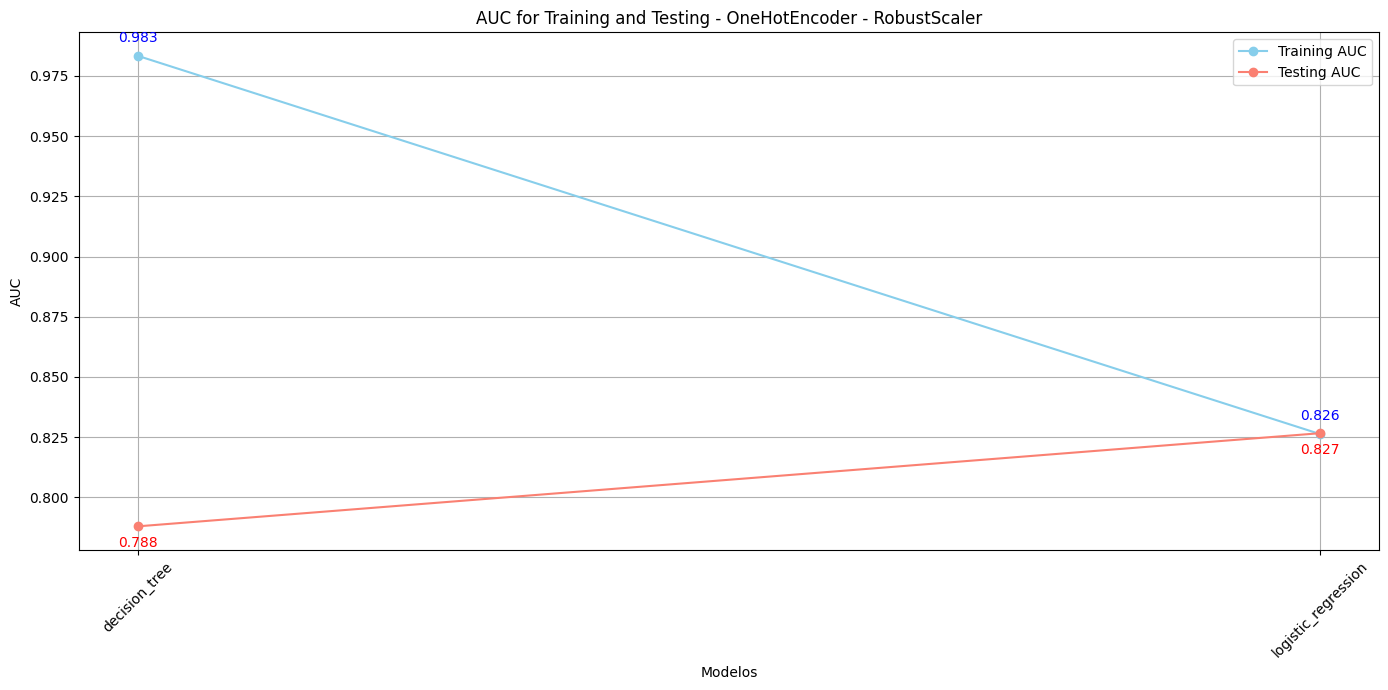

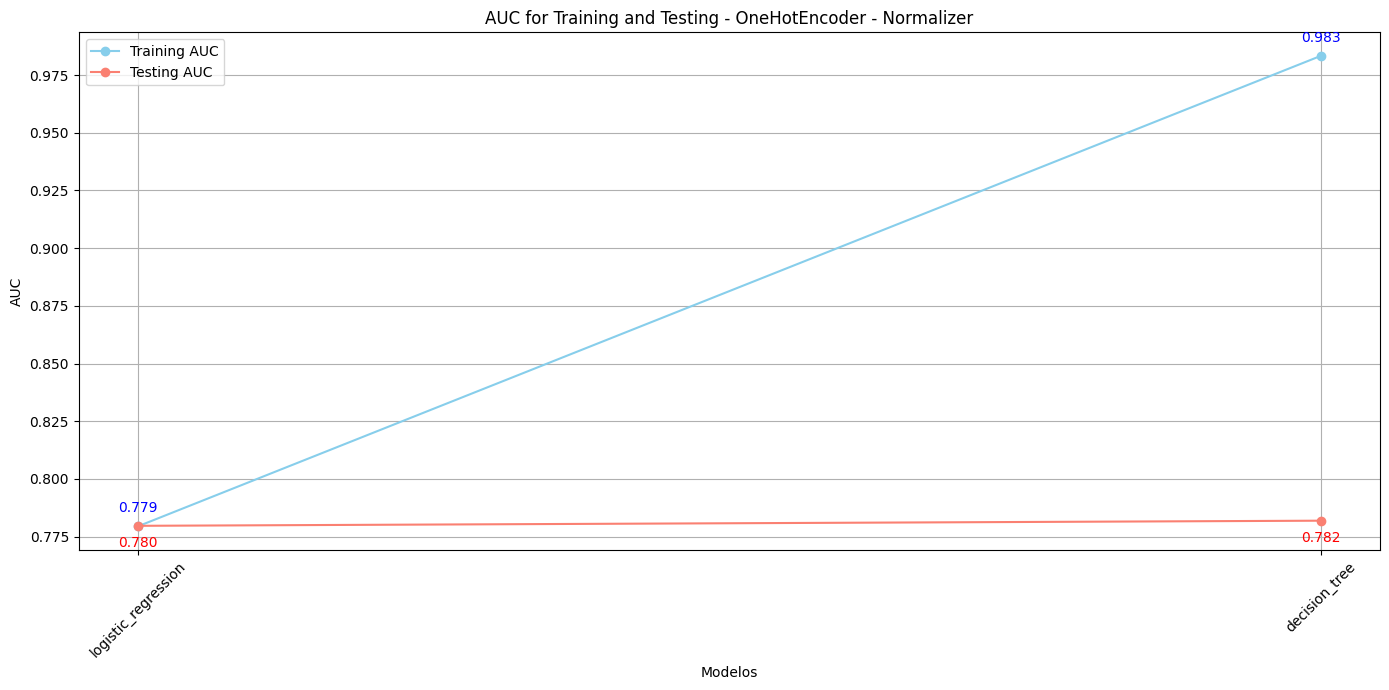

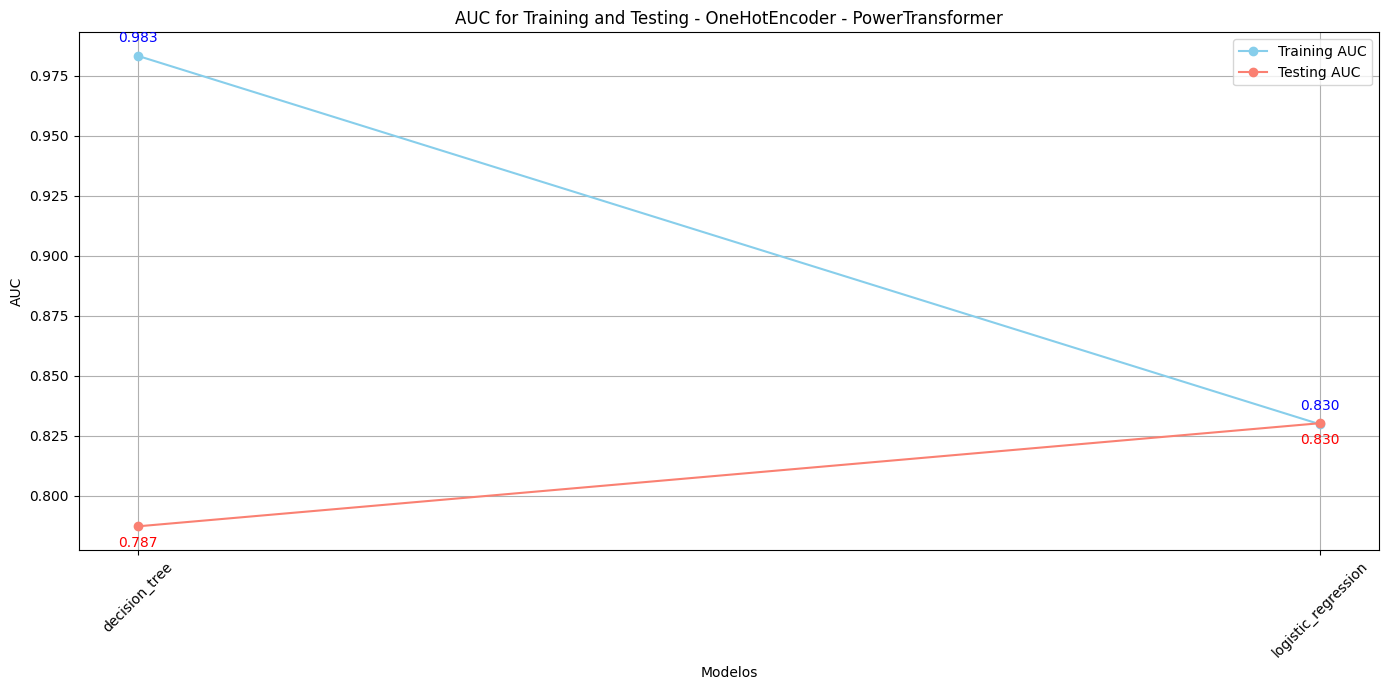

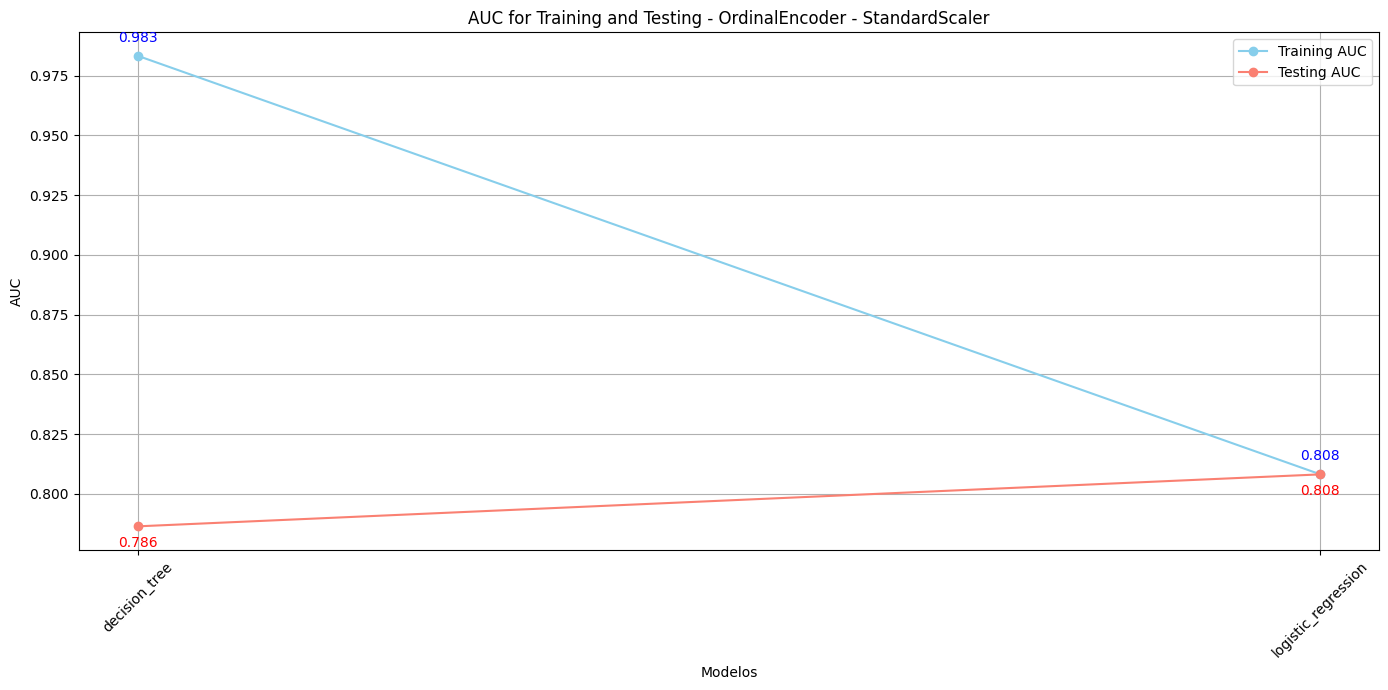

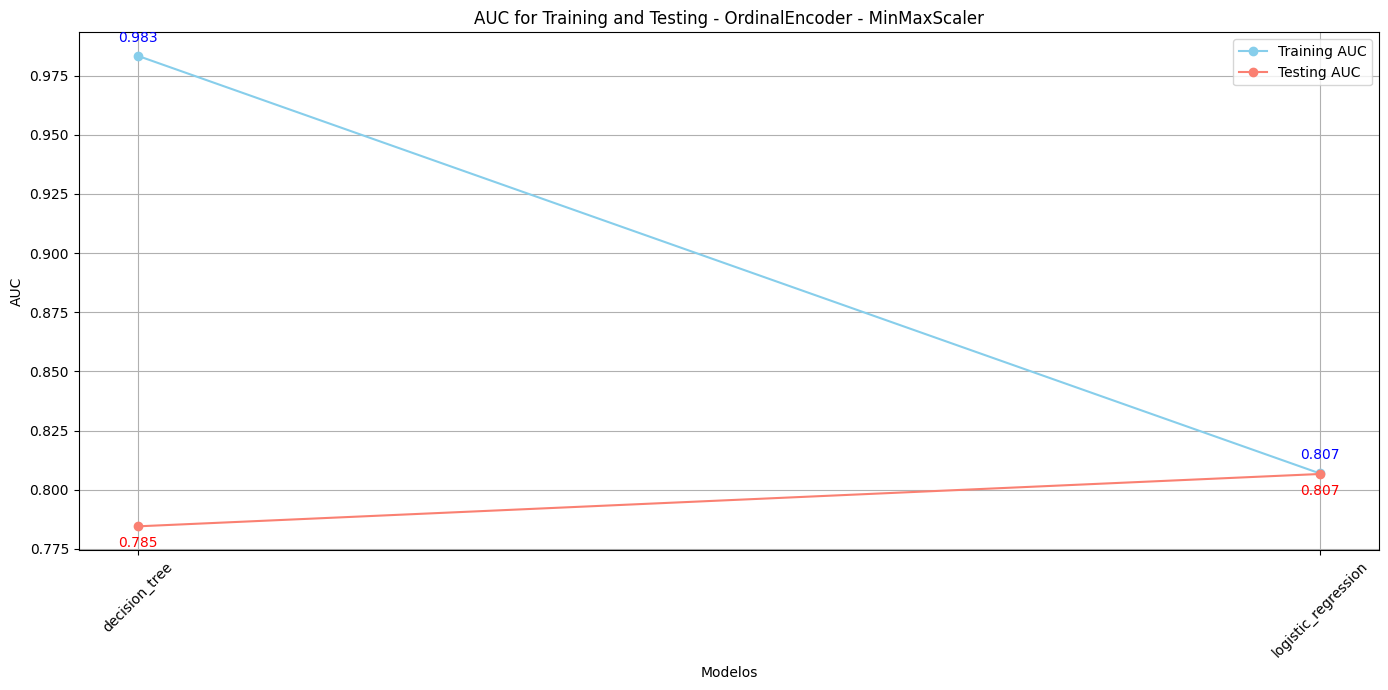

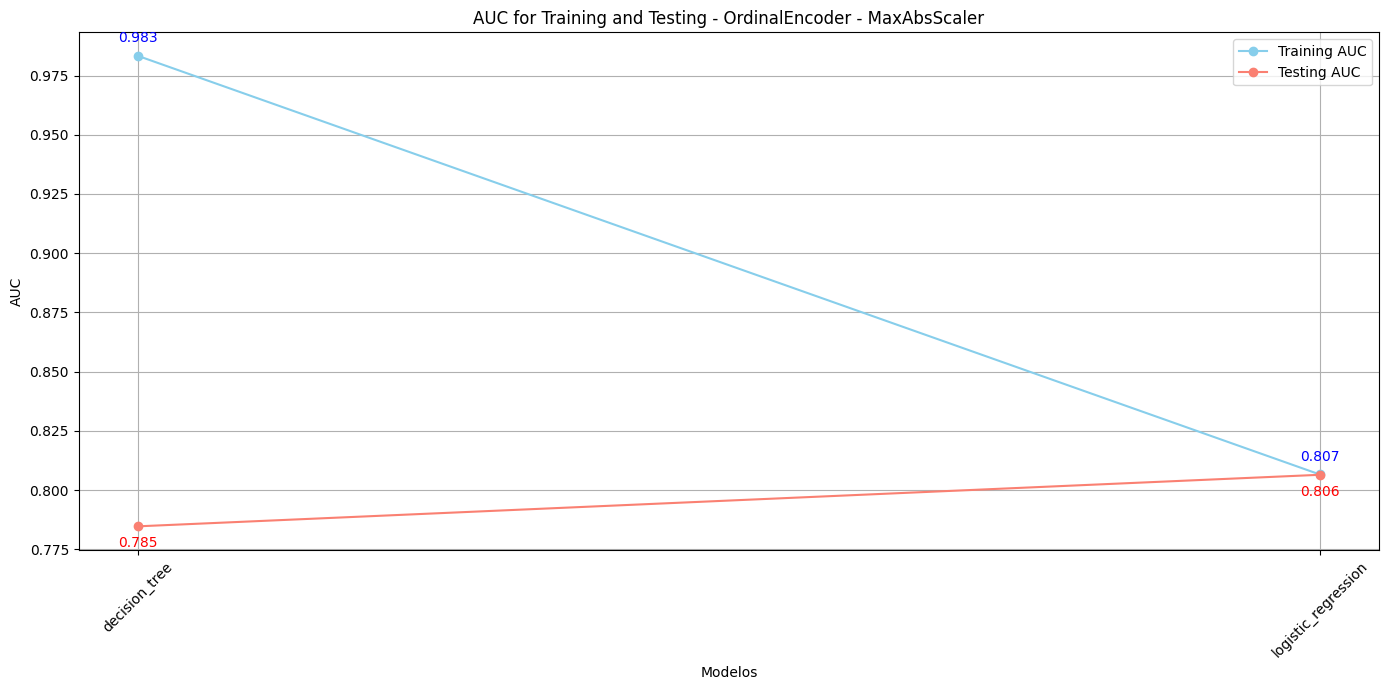

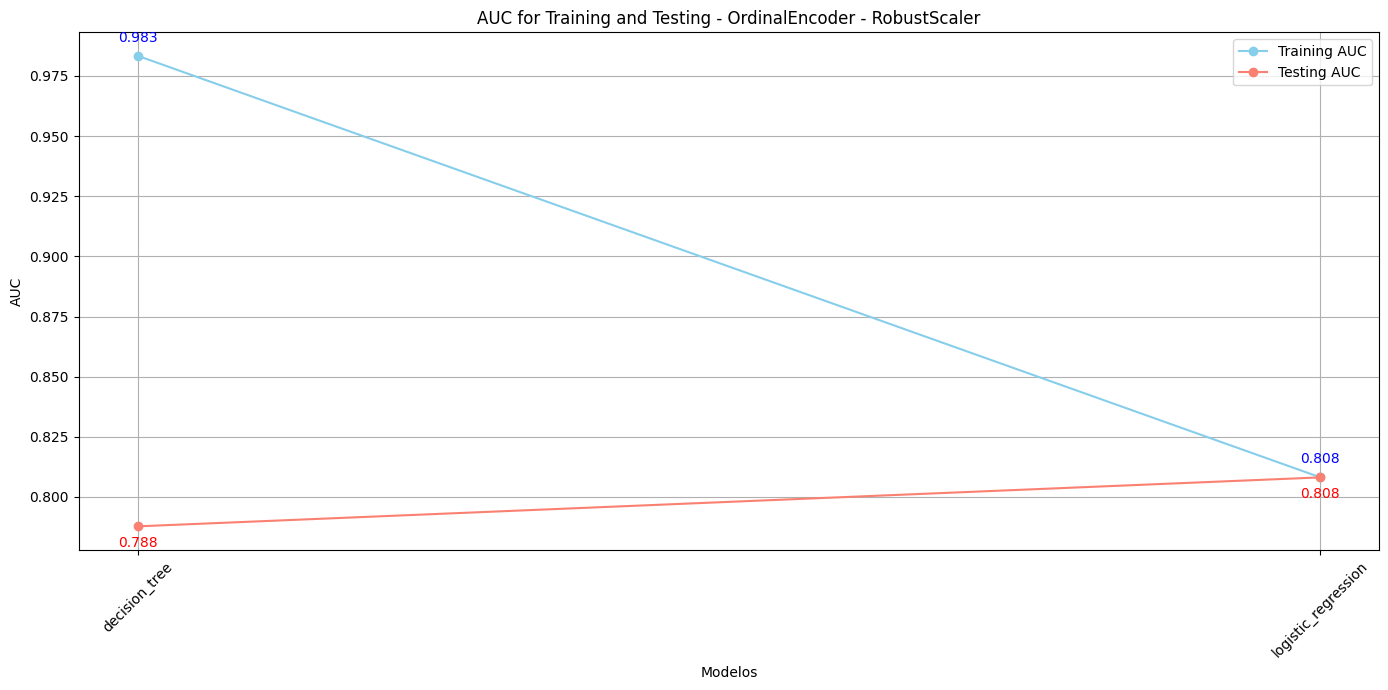

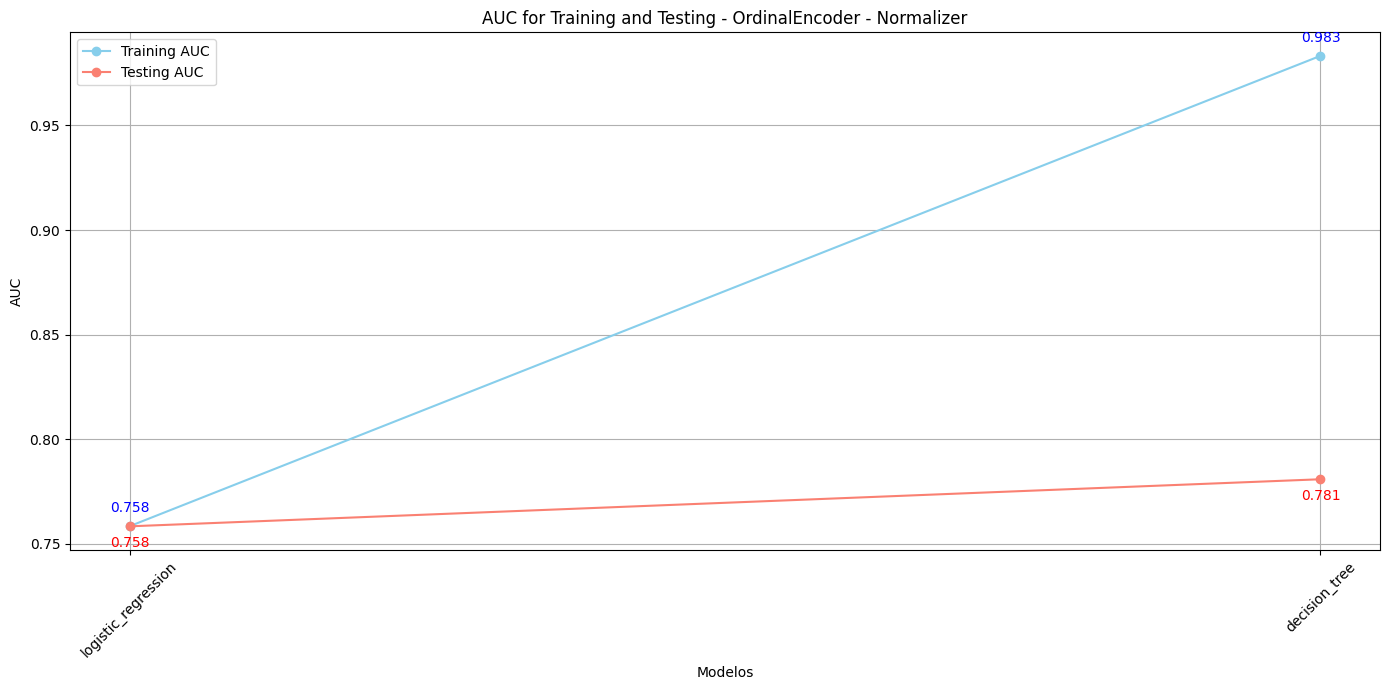

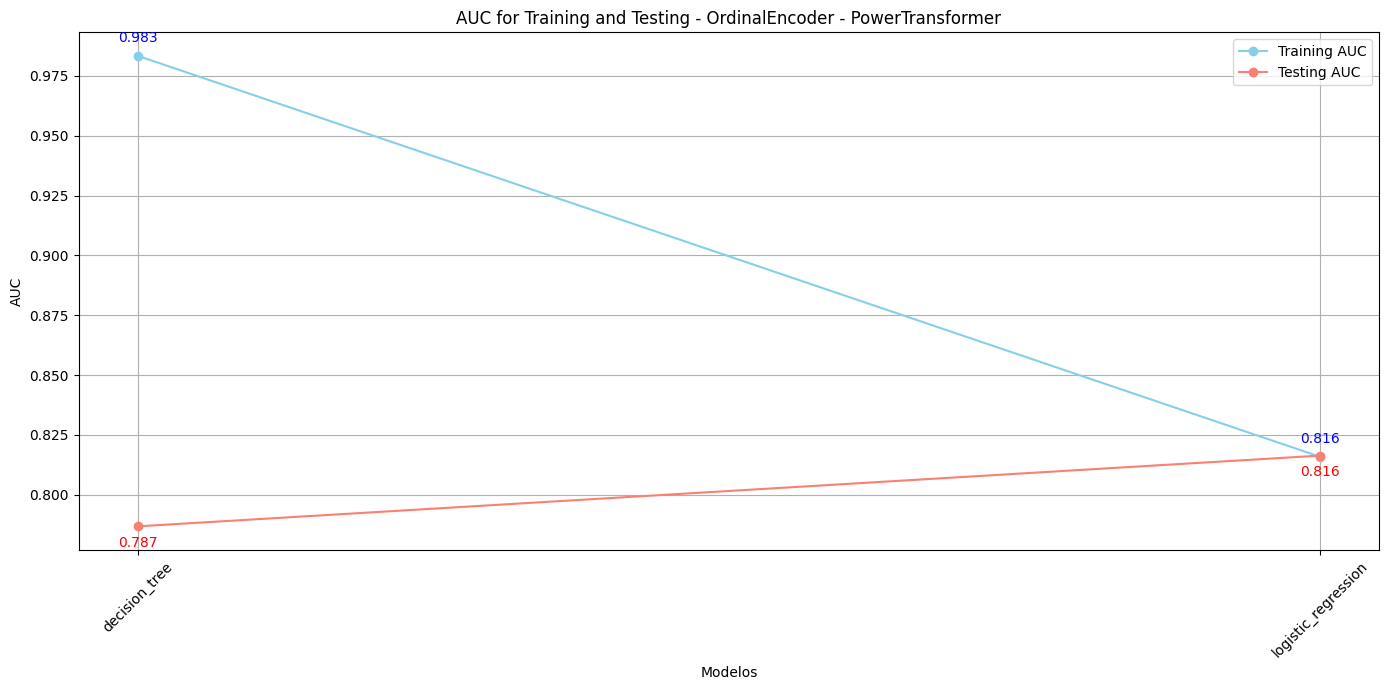

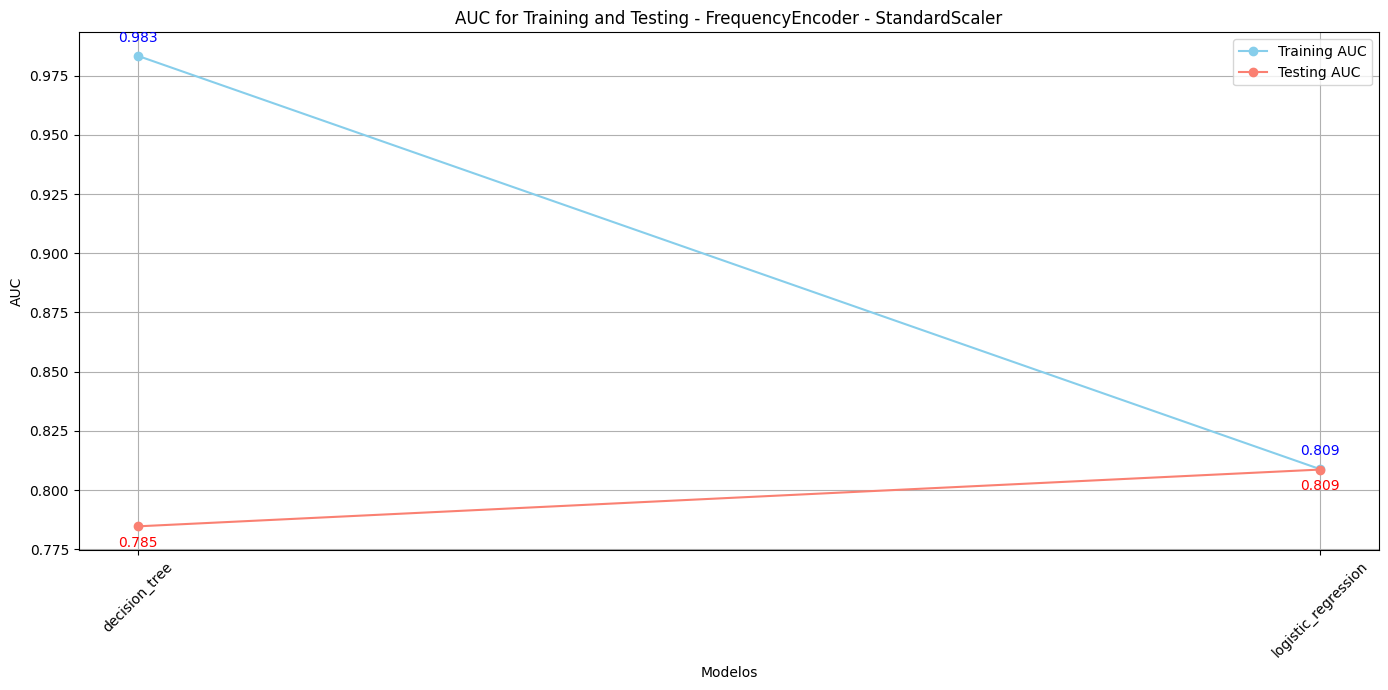

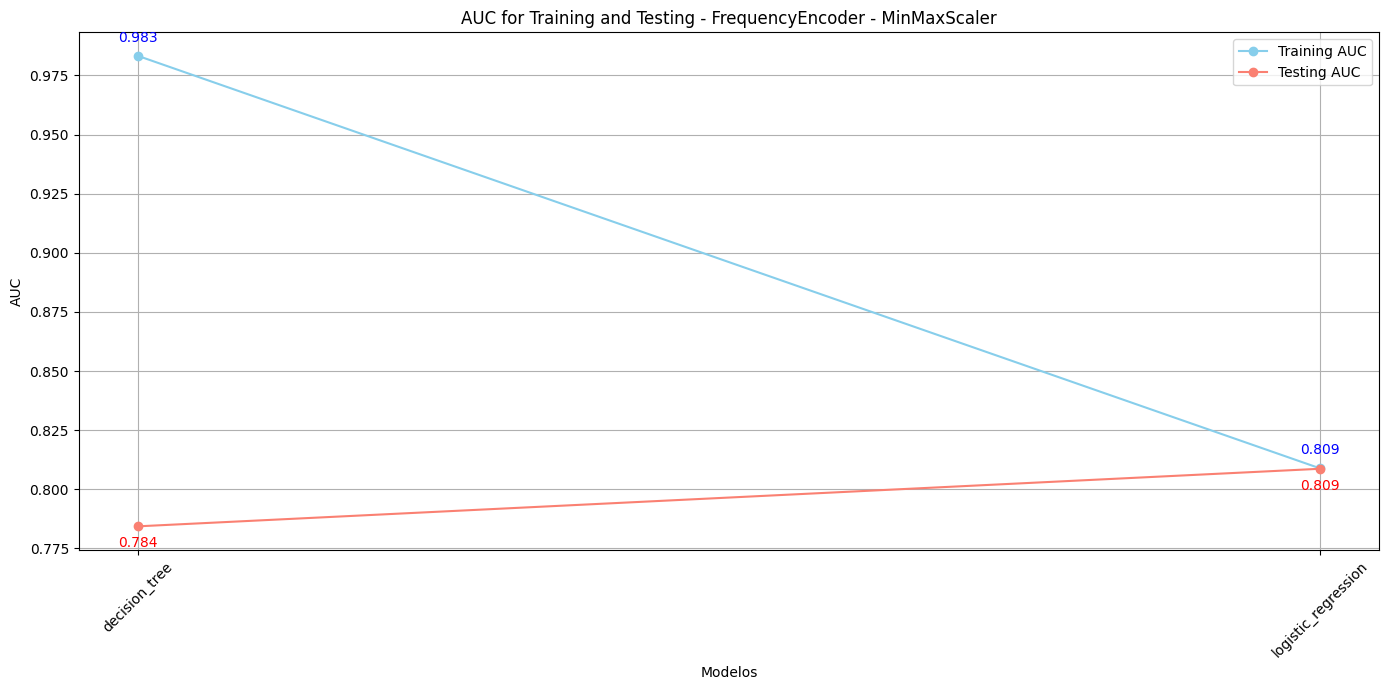

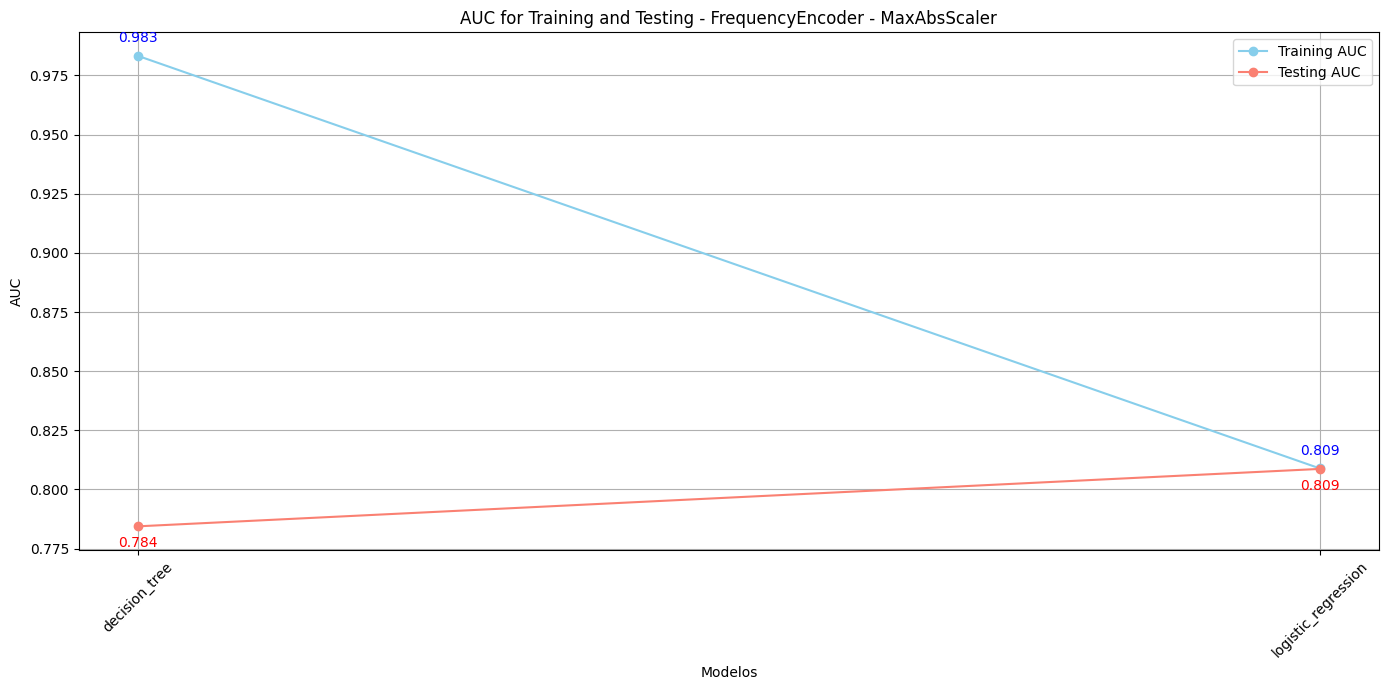

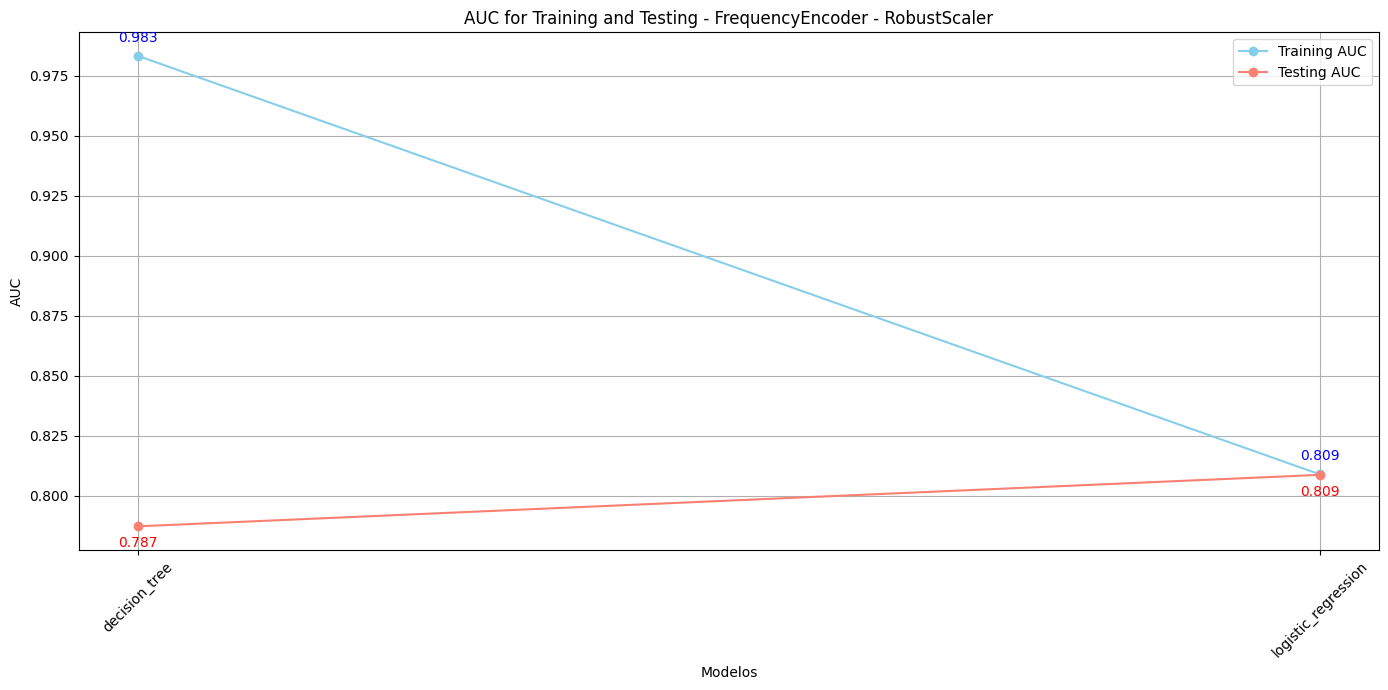

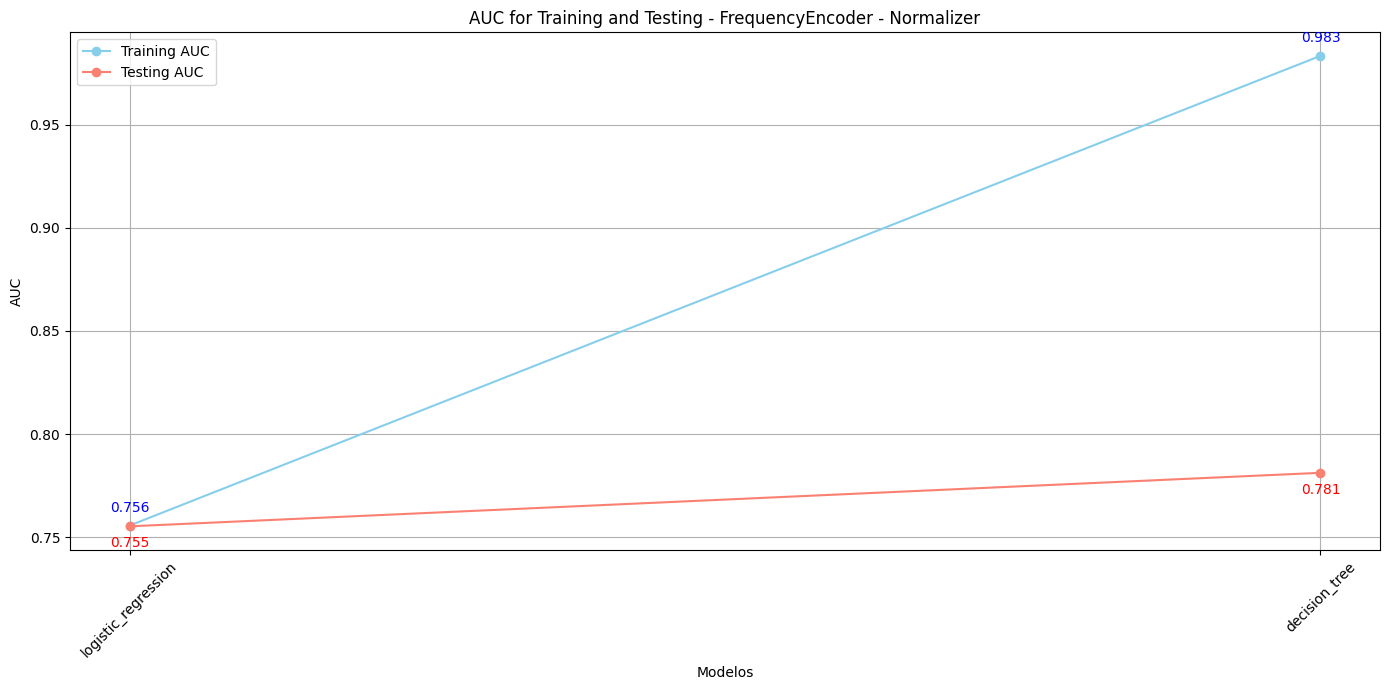

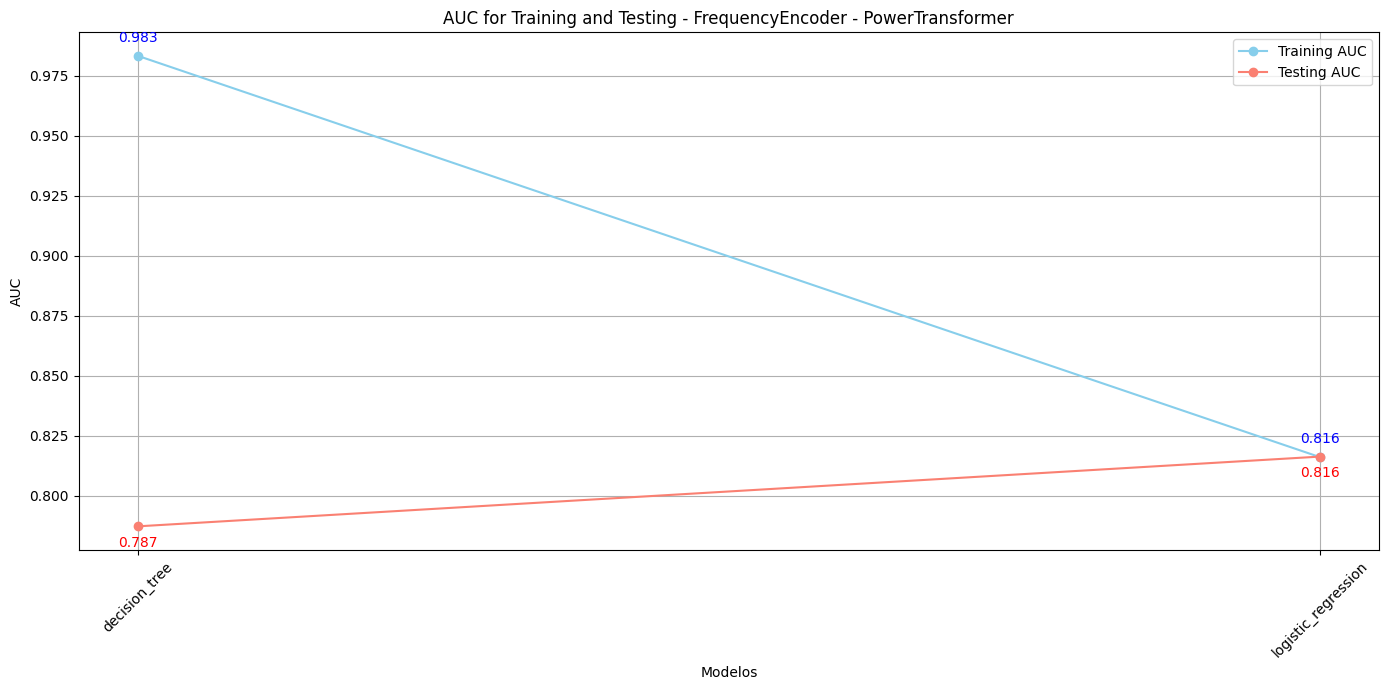

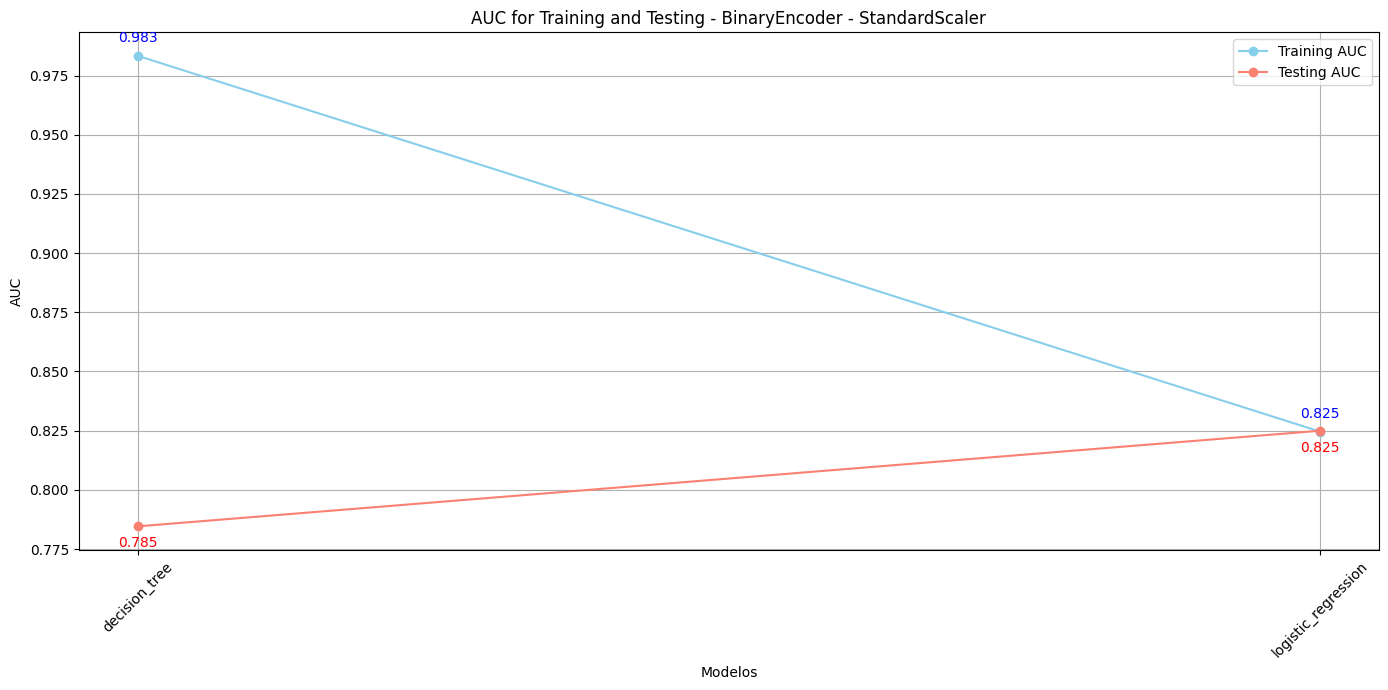

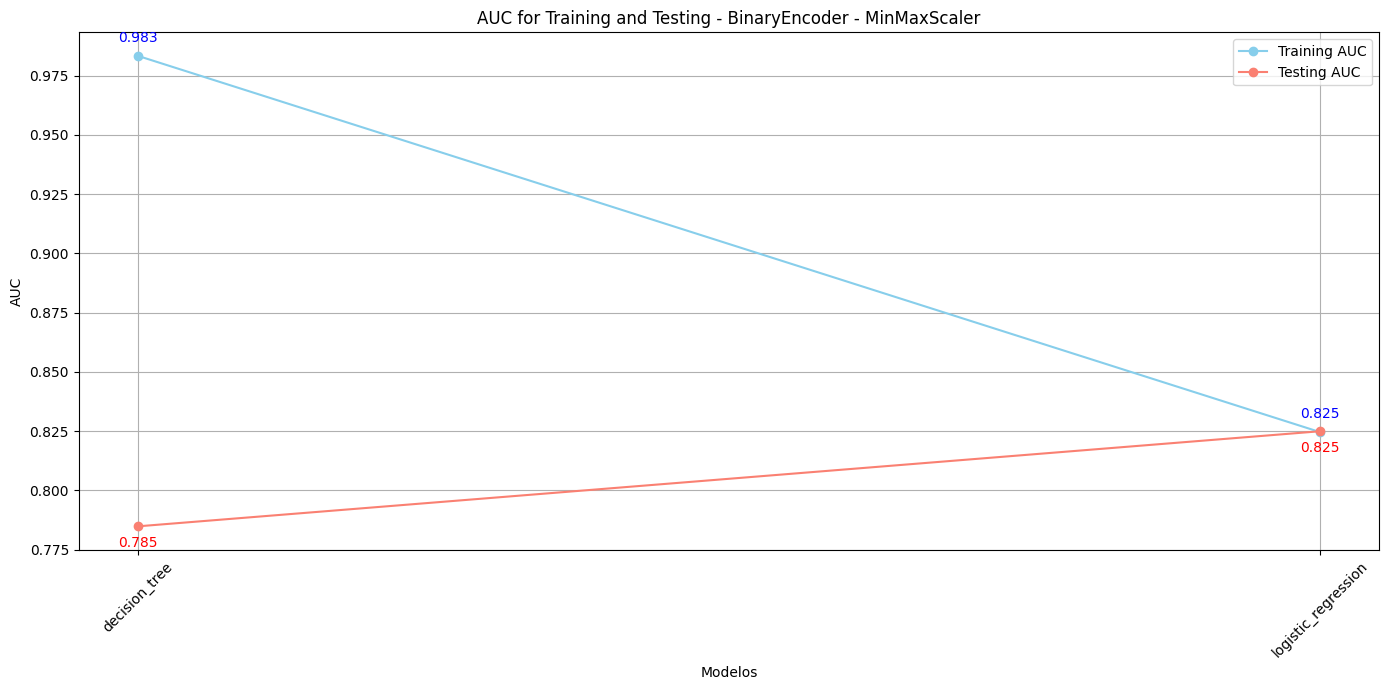

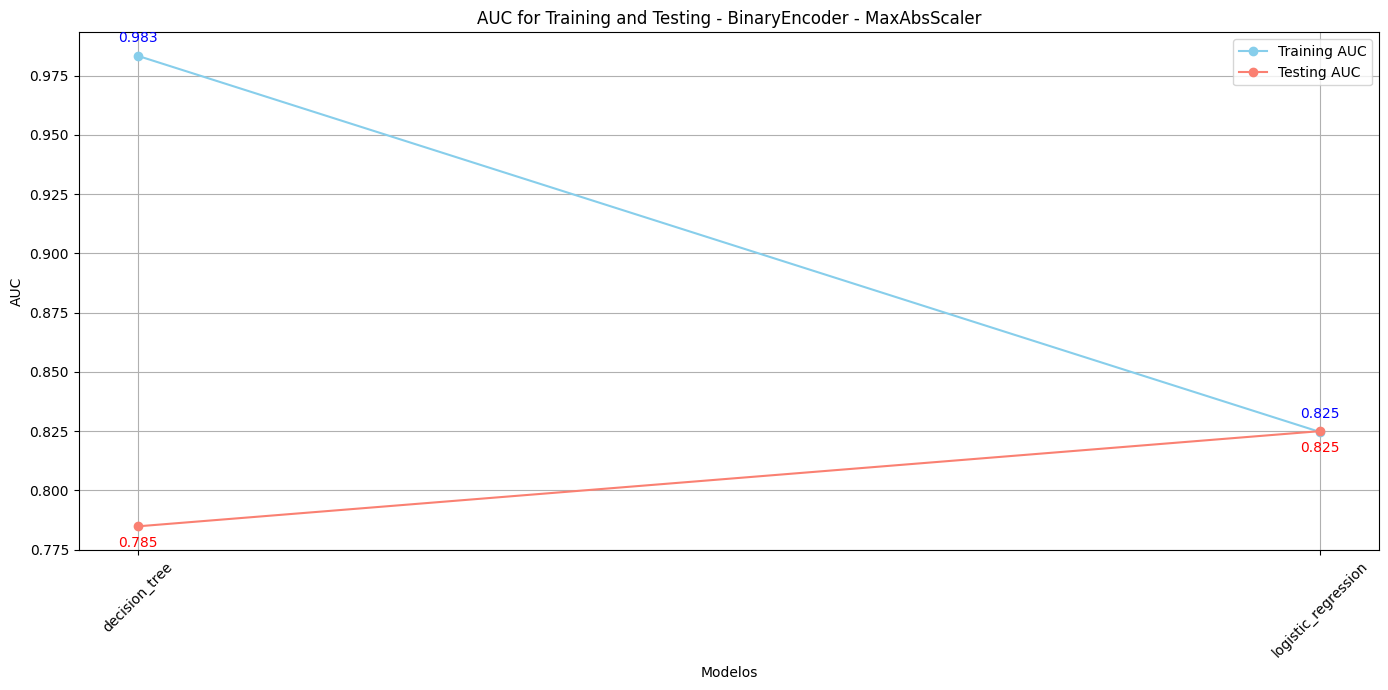

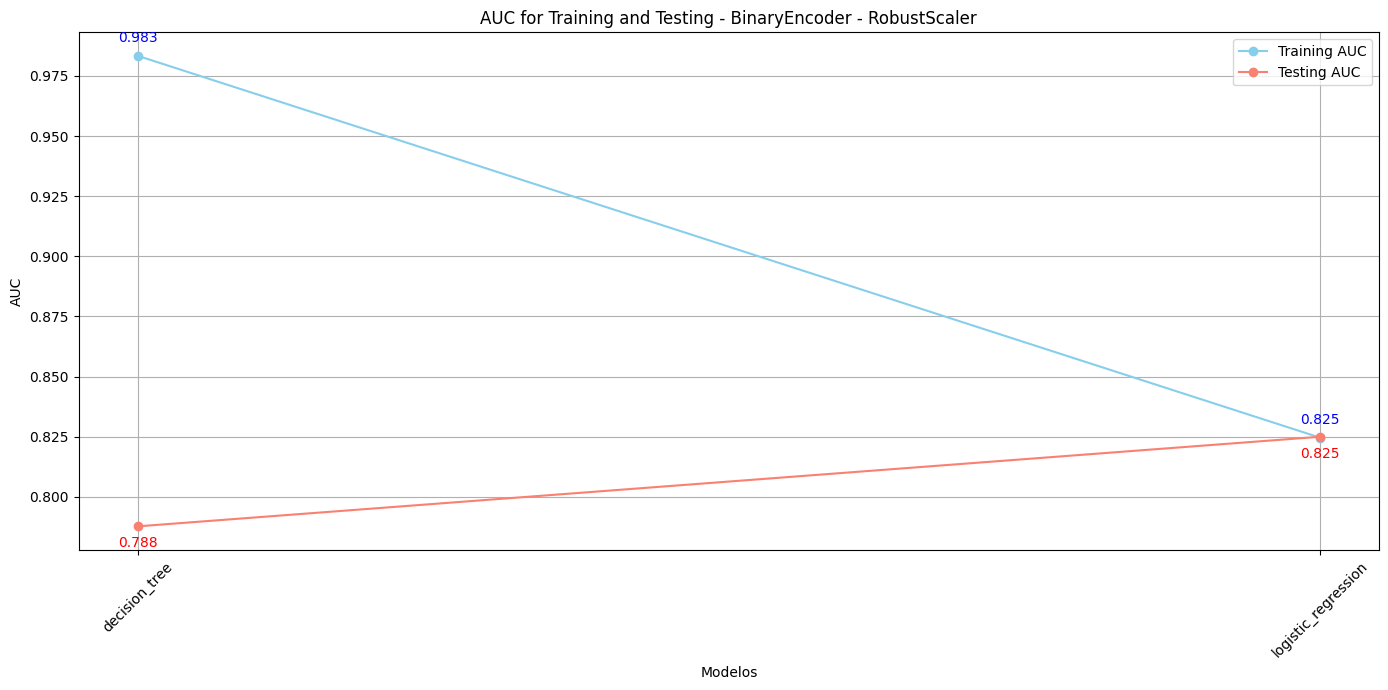

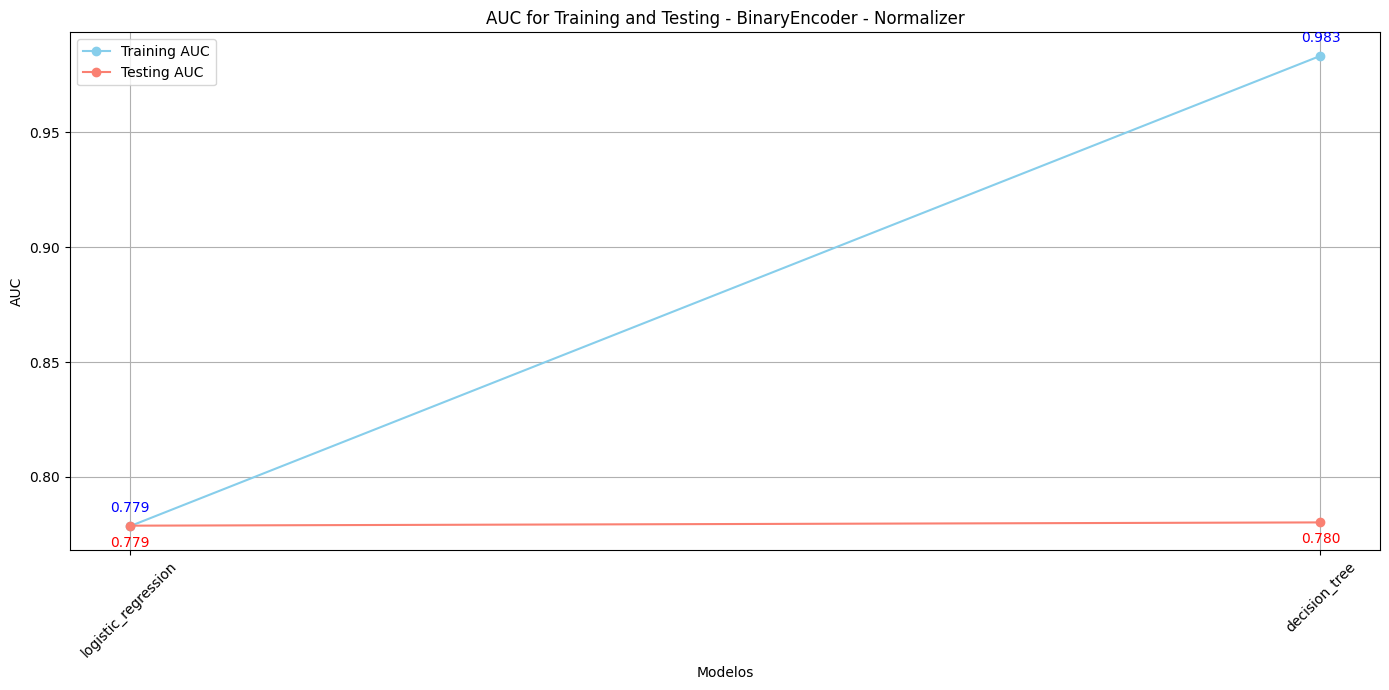

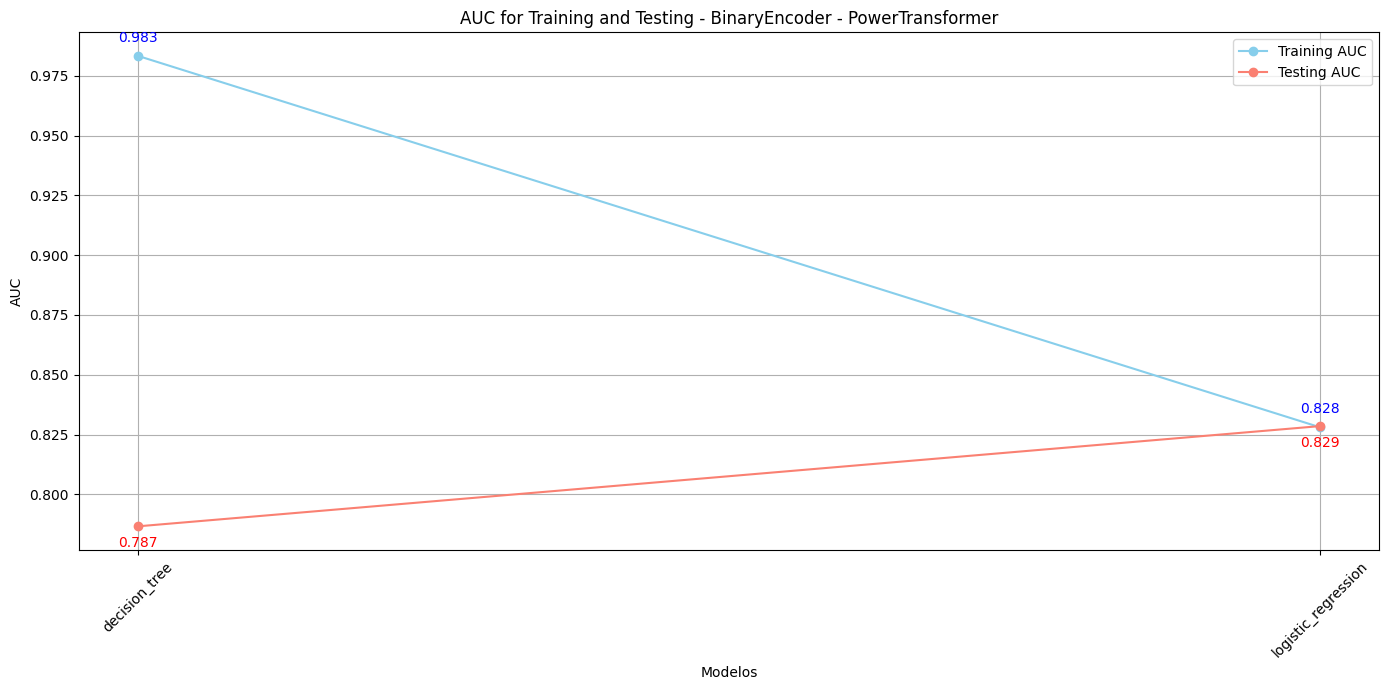

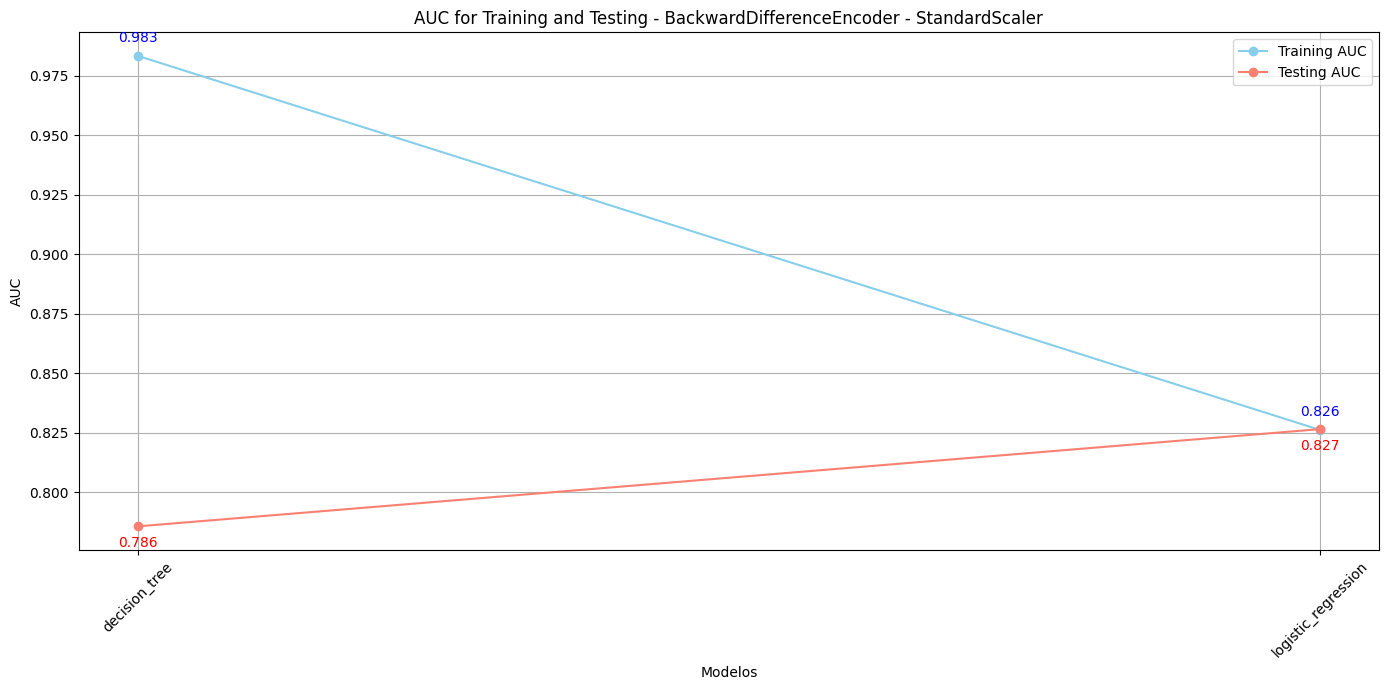

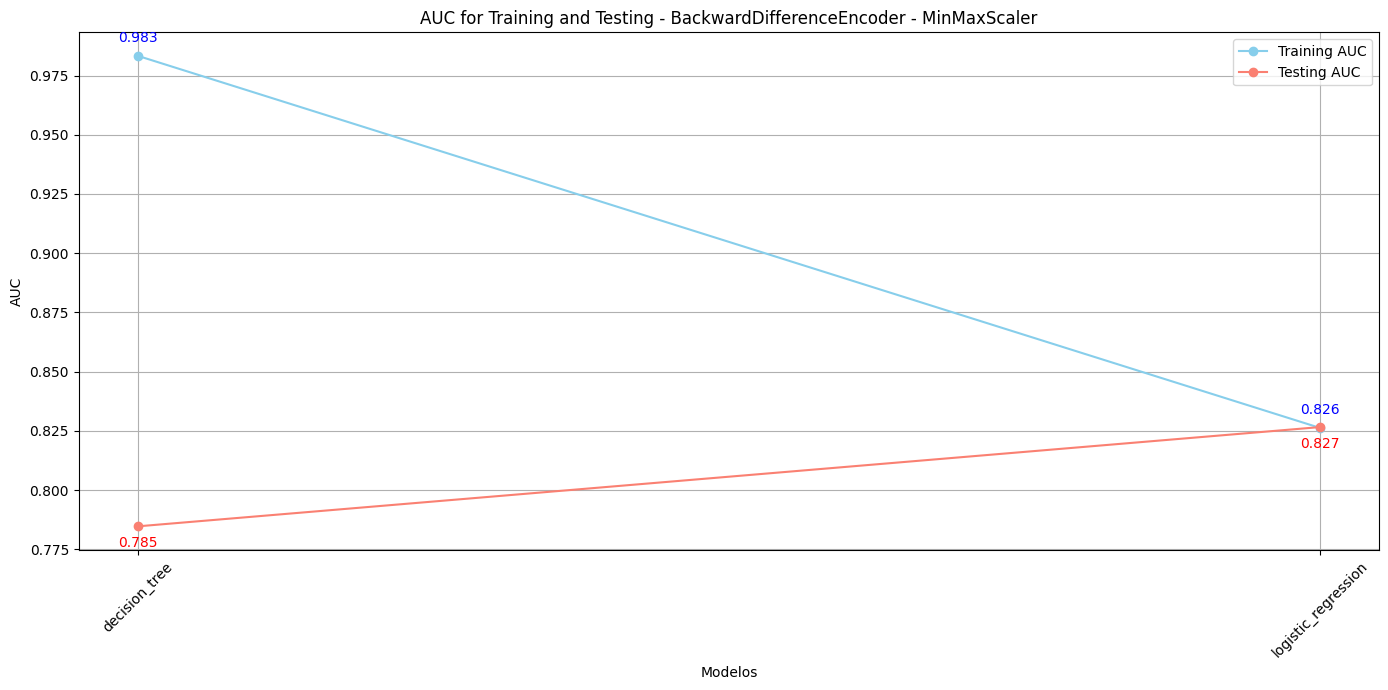

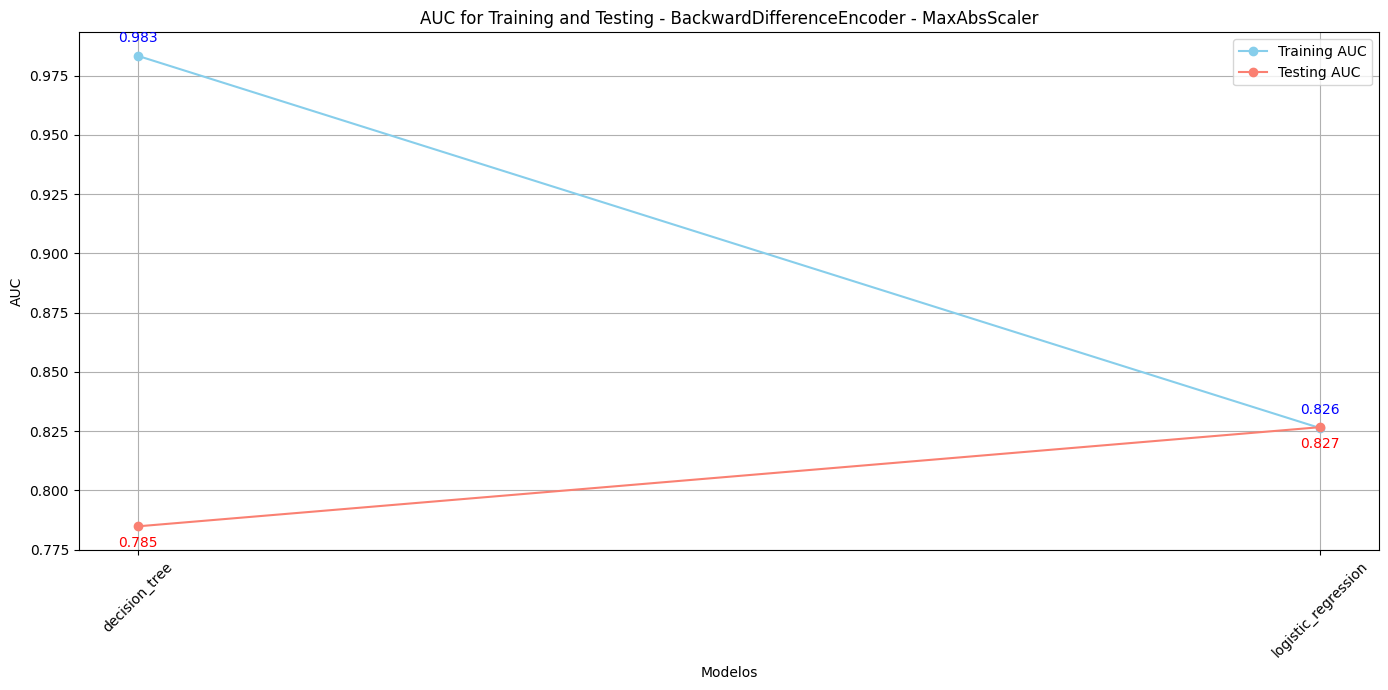

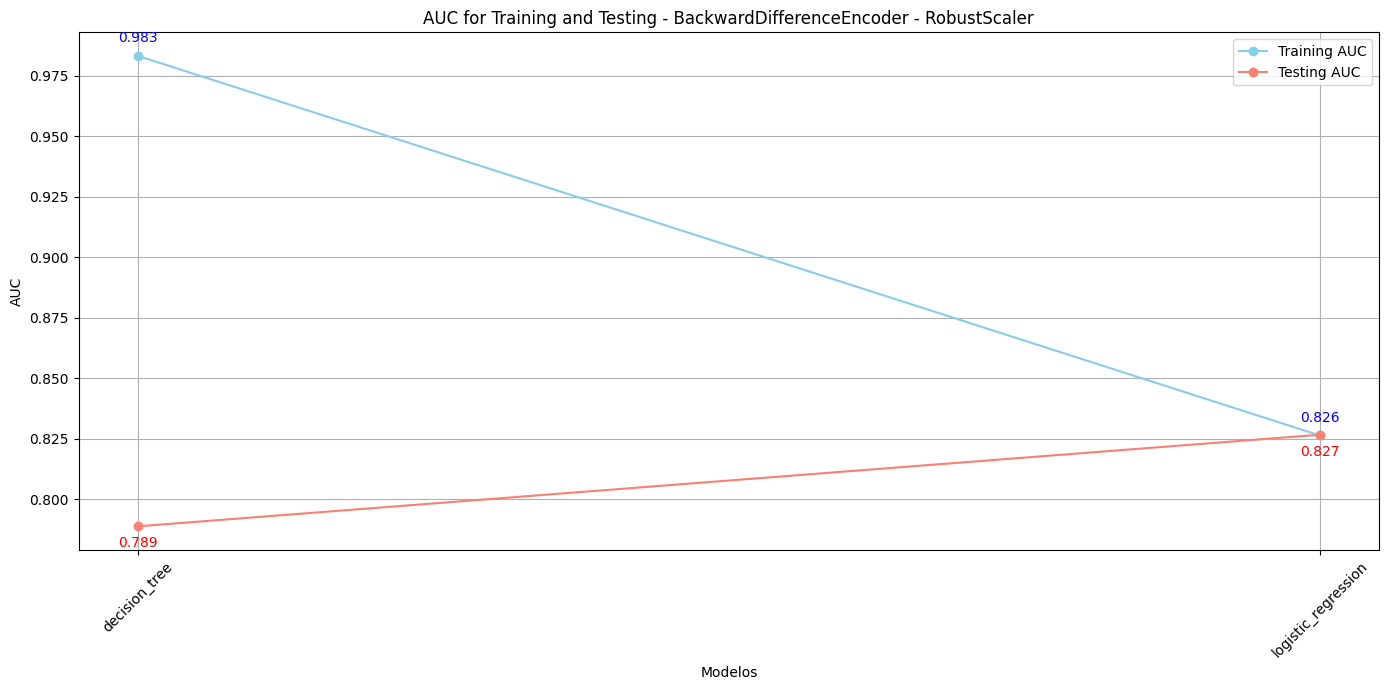

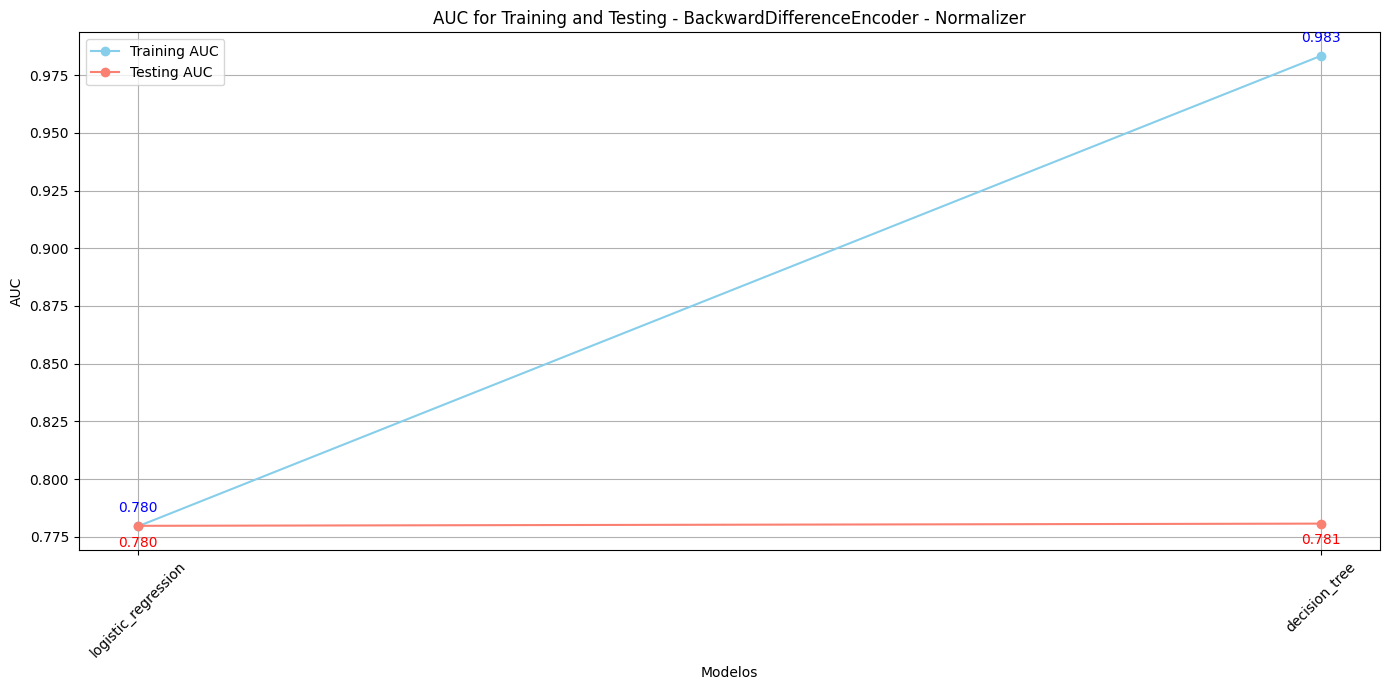

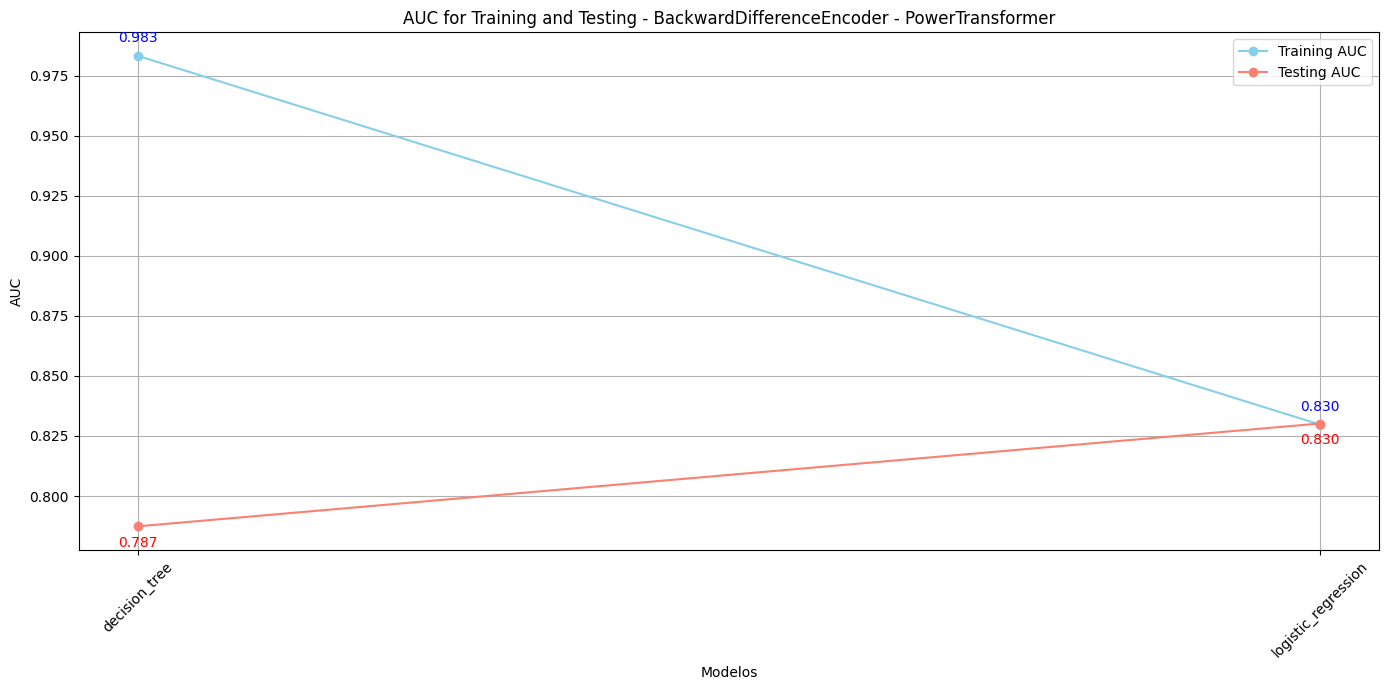

In [22]:
def plot_results(all_results):
    for encoded_method, sorted_names, train_aucs, test_aucs, _, _ in all_results:
        # Ordenar los resultados por Testing AUC de menor a mayor
        sorted_indices = np.argsort(test_aucs)
        sorted_names = np.array(sorted_names)[sorted_indices]
        train_aucs = np.array(train_aucs)[sorted_indices]
        test_aucs = np.array(test_aucs)[sorted_indices]

        plt.figure(figsize=(14, 7))

        # Gráfico de líneas
        plt.plot(sorted_names, train_aucs, label='Training AUC', marker='o', color='skyblue')
        plt.plot(sorted_names, test_aucs, label='Testing AUC', marker='o', color='salmon')

        # Añadir los valores a los puntos
        for i, txt in enumerate(train_aucs):
            plt.annotate(f'{txt:.3f}', (sorted_names[i], train_aucs[i]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
        for i, txt in enumerate(test_aucs):
            plt.annotate(f'{txt:.3f}', (sorted_names[i], test_aucs[i]), textcoords="offset points", xytext=(0,-15), ha='center', color='red')

        plt.xlabel('Modelos')
        plt.ylabel('AUC')
        plt.title(f'AUC for Training and Testing - {encoded_method}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Llamar a la función para generar los gráficos
plot_results(all_results)

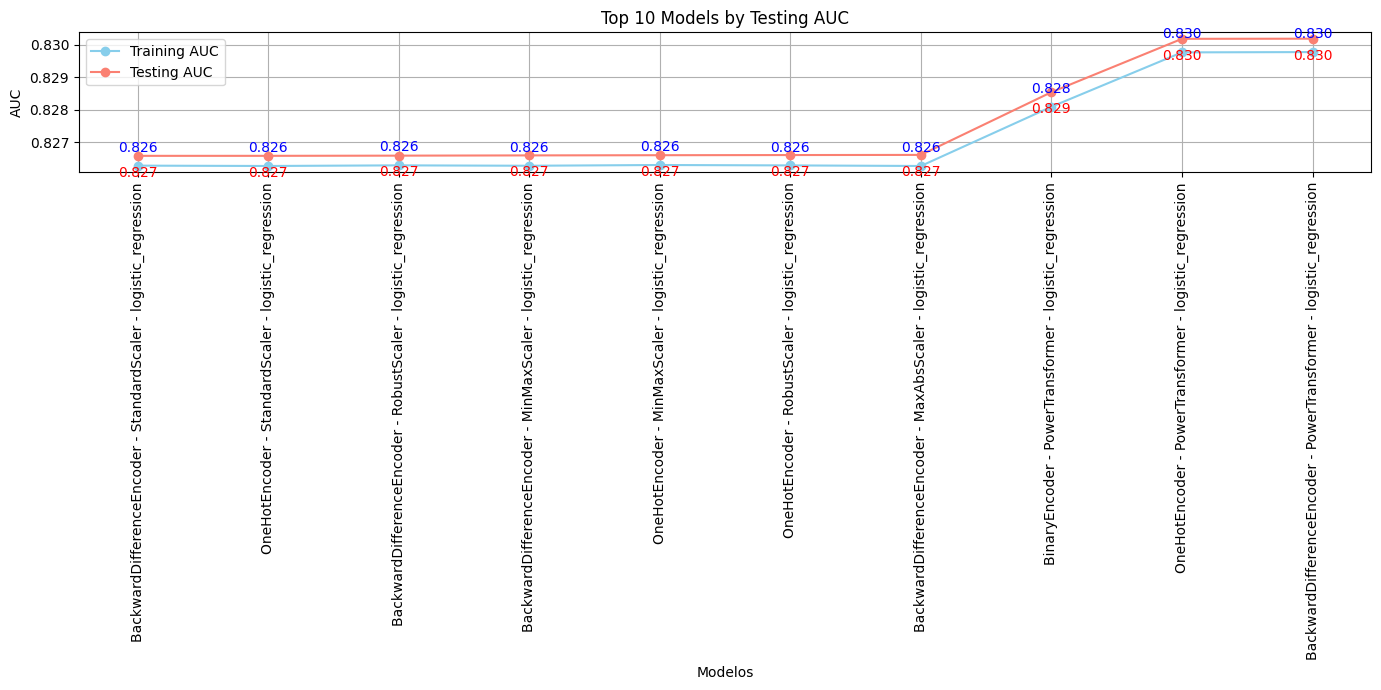

In [23]:
# Consolidar todos los resultados en una lista
consolidated_results = []
for encoded_method, sorted_names, train_aucs, test_aucs, _, _ in all_results:
    for name, train_auc, test_auc in zip(sorted_names, train_aucs, test_aucs):
        full_model_name = f"{encoded_method} - {name}"
        consolidated_results.append((full_model_name, train_auc, test_auc))

# Ordenar los resultados por test_auc de mayor a menor y seleccionar el top 10
consolidated_results.sort(key=lambda x: x[2], reverse=False)
top_10_results = consolidated_results[-10:]

# Desempaquetar los resultados del top 10
top_10_names, top_10_train_aucs, top_10_test_aucs = zip(*top_10_results)

plt.figure(figsize=(14, 7))

# Gráfico de líneas para el top 10
plt.plot(top_10_names, top_10_train_aucs, label='Training AUC', marker='o', color='skyblue')
plt.plot(top_10_names, top_10_test_aucs, label='Testing AUC', marker='o', color='salmon')

# Añadir los valores a los puntos
for i, txt in enumerate(top_10_train_aucs):
    plt.annotate(f'{txt:.3f}', (top_10_names[i], top_10_train_aucs[i]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
for i, txt in enumerate(top_10_test_aucs):
    plt.annotate(f'{txt:.3f}', (top_10_names[i], top_10_test_aucs[i]), textcoords="offset points", xytext=(0,-15), ha='center', color='red')

plt.xlabel('Modelos')
plt.ylabel('AUC')
plt.title('Top 10 Models by Testing AUC')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
